In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_90k_tns_df.csv', index_col='ztf_object_id')
dataset_bank_tns_df

,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,
ZTF20acpdyyq,No_TNS,None,-99.0,None
ZTF18acfvwwa,No_TNS,None,-99.0,None
ZTF17aaaskvj,No_TNS,None,-99.0,None
ZTF18aczbnhl,No_TNS,None,-99.0,None
ZTF18actbhqt,No_TNS,None,-99.0,None
...,...,...,...,...
ZTF18adairvu,No_TNS,None,-99.0,None
ZTF20aaiwhct,No_TNS,None,-99.0,None
ZTF20aberawv,No_TNS,None,-99.0,None


In [3]:
suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_sep_highlighted"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_noSS_AlerceCls_fw_MI_classif_LConly"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_noSS_AlerceCls_fw_MI_classif_only2"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_MI_classif_only"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_MI_classif_highlight_sepFs"
#suffix=f"noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_fromDict"

ann_num = 350
col_list= [f'dist={col}' for col in range(1, ann_num)]
dist_col = f'Max-{len(col_list)}ANNs'


ann_dist_all_df = pd.read_csv(f'ann_dist_all_df_{suffix}_ann_num={ann_num}.csv', index_col=0)
ann_dist_all_df.index = ann_dist_all_df.index.rename('ztf_object_id')
ann_dist_all_df

,Mean-349ANNs,Max-349ANNs
ztf_object_id,,
ZTF17aaahrni,762.419978,918.853699
ZTF17aadqidc,558.473896,670.652649
ZTF18aabdnbr,869.655568,1030.674805
ZTF18aabeszt,642.313242,774.563782
ZTF18aabvmws,590.310669,735.028931
...,...,...
ZTF21ackmpcb,661.418709,788.330017
ZTF21ackwyaz,670.632390,794.411255
ZTF21ackzfeh,997.258465,1183.260864


In [4]:
merge_df = pd.concat([ann_dist_all_df, dataset_bank_tns_df], axis=1)
merge_df = merge_df[~merge_df.isnull().any(axis=1)]
merge_df

,Mean-349ANNs,Max-349ANNs,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,
ZTF17aaahrni,762.419978,918.853699,Yes_TNS,None,-99.000,GaiaAlerts
ZTF17aadqidc,558.473896,670.652649,No_TNS,None,-99.000,None
ZTF18aabdnbr,869.655568,1030.674805,Yes_TNS,None,-99.000,ALeRCE
ZTF18aabeszt,642.313242,774.563782,Yes_TNS,SN Ia,0.081,ALeRCE
ZTF18aabvmws,590.310669,735.028931,Yes_TNS,None,-99.000,ZTF
...,...,...,...,...,...,...
ZTF21ackmpcb,661.418709,788.330017,Yes_TNS,None,-99.000,ALeRCE
ZTF21ackwyaz,670.632390,794.411255,Yes_TNS,None,-99.000,ALeRCE
ZTF21ackzfeh,997.258465,1183.260864,Yes_TNS,None,-99.000,ALeRCE


In [5]:
MO_df = merge_df[(merge_df[dist_col]>=4000) & (merge_df.has_tns == 'No_TNS')]

for sn in MO_df.index:
    print(f'https://alerce.online/object/{sn}')

<ipython-input-6-03ac10b41d7a>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


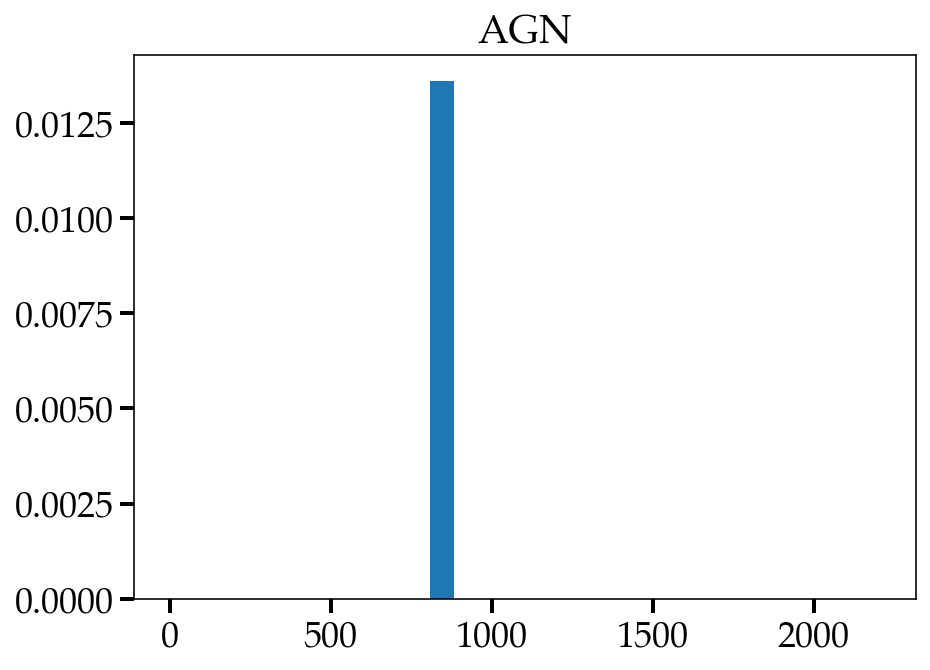

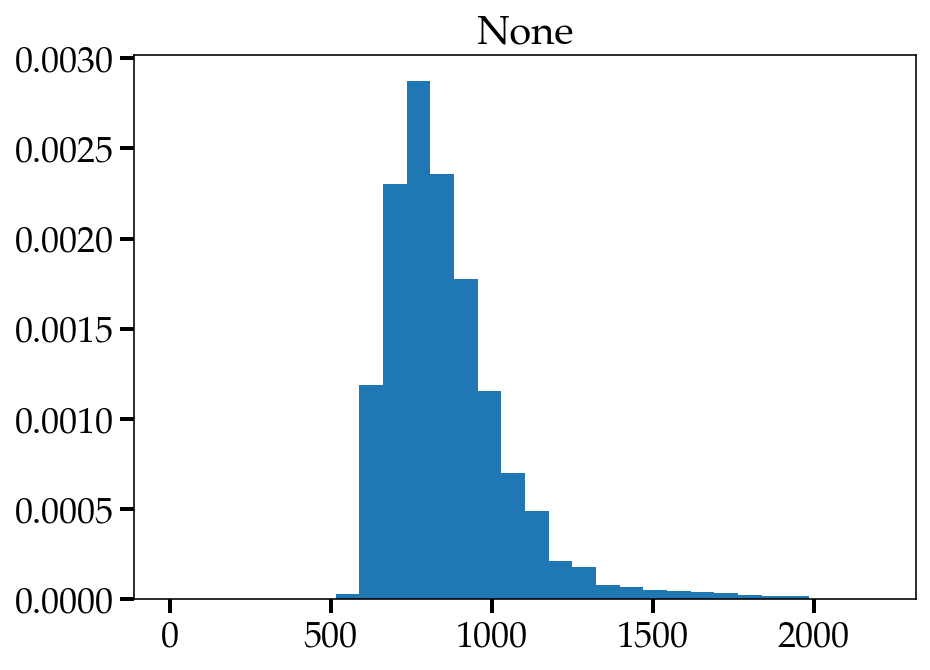

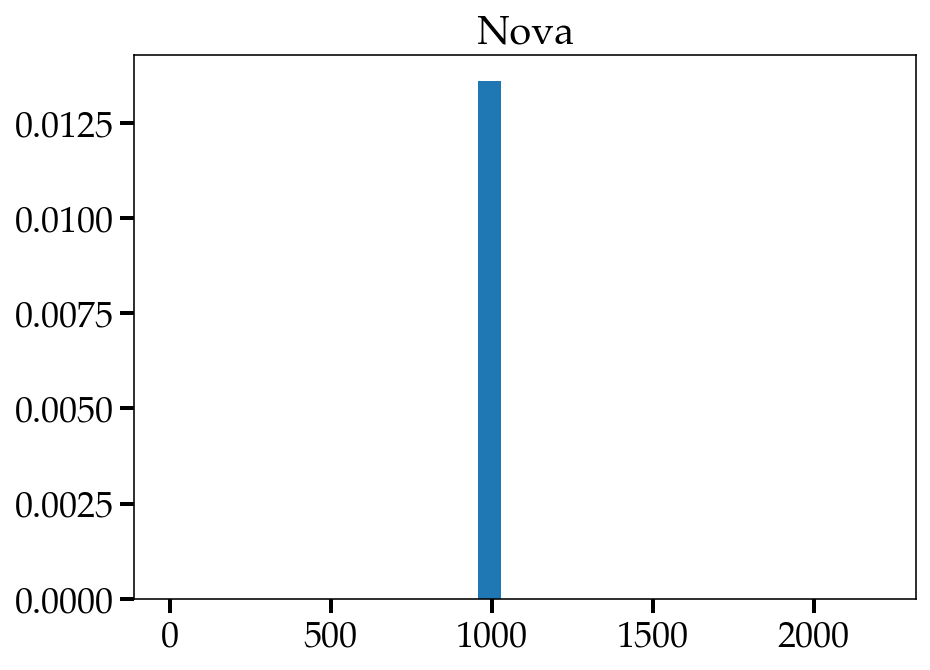

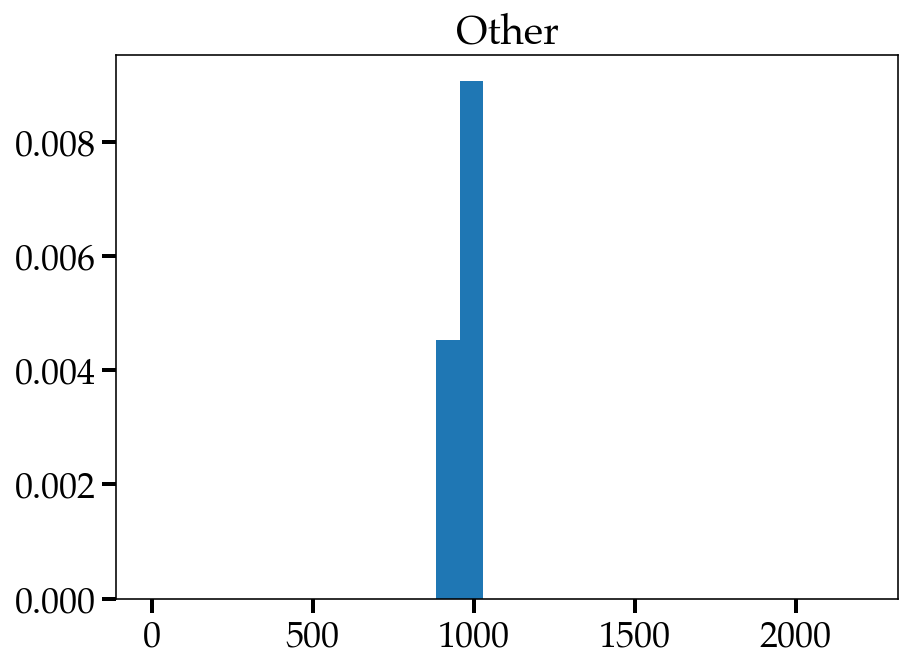

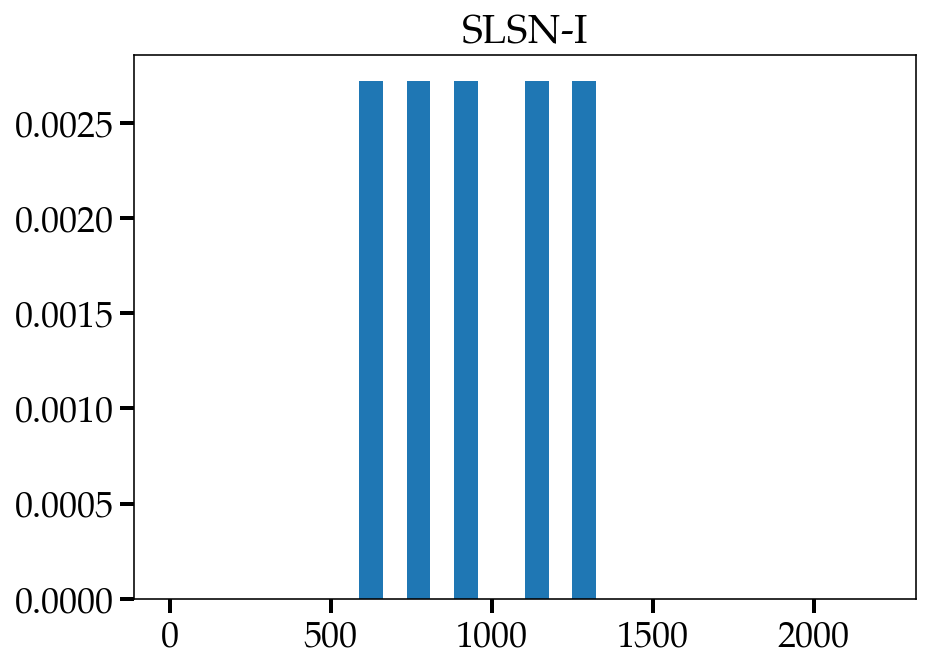

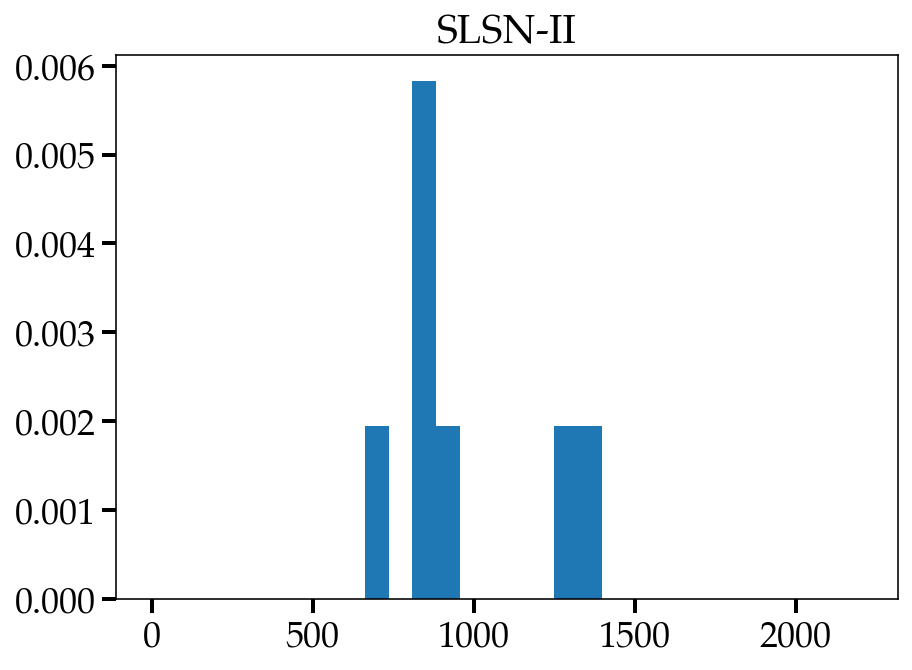

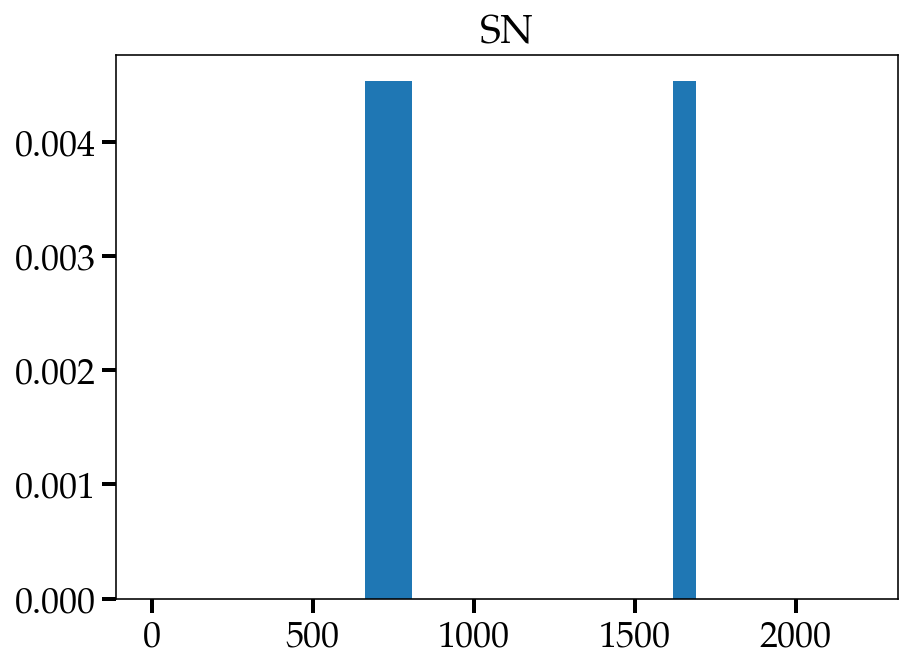

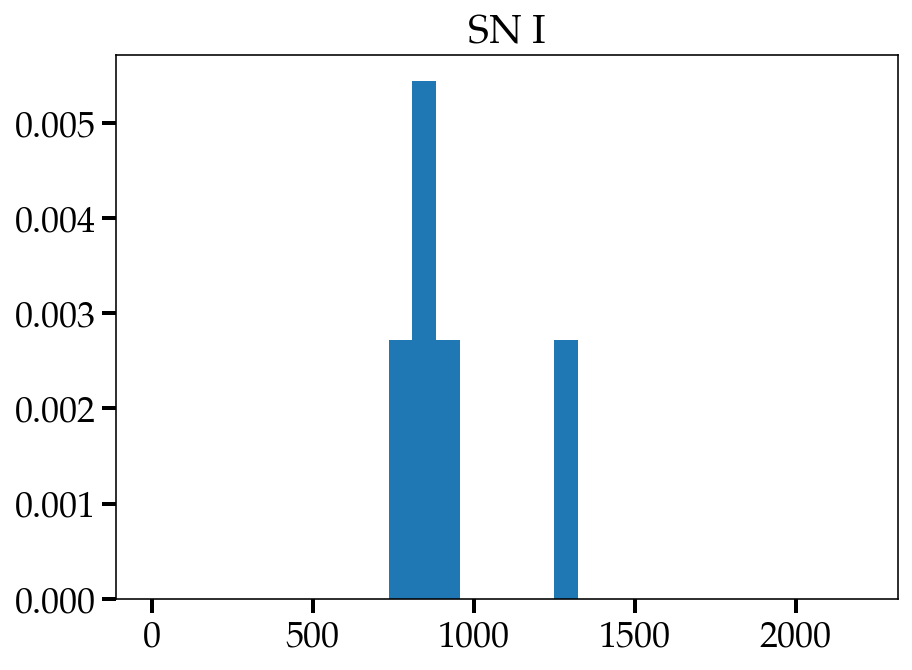

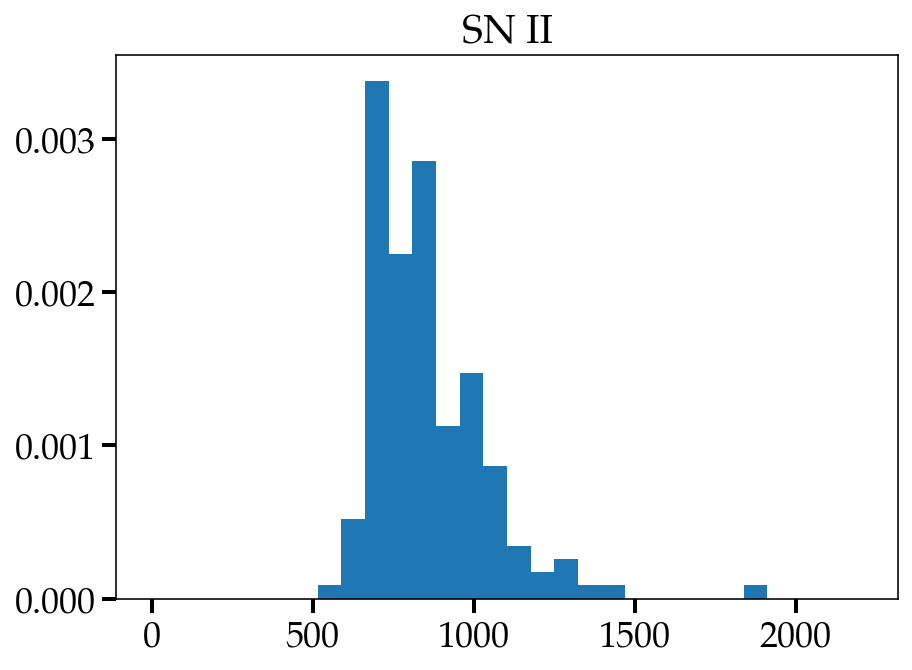

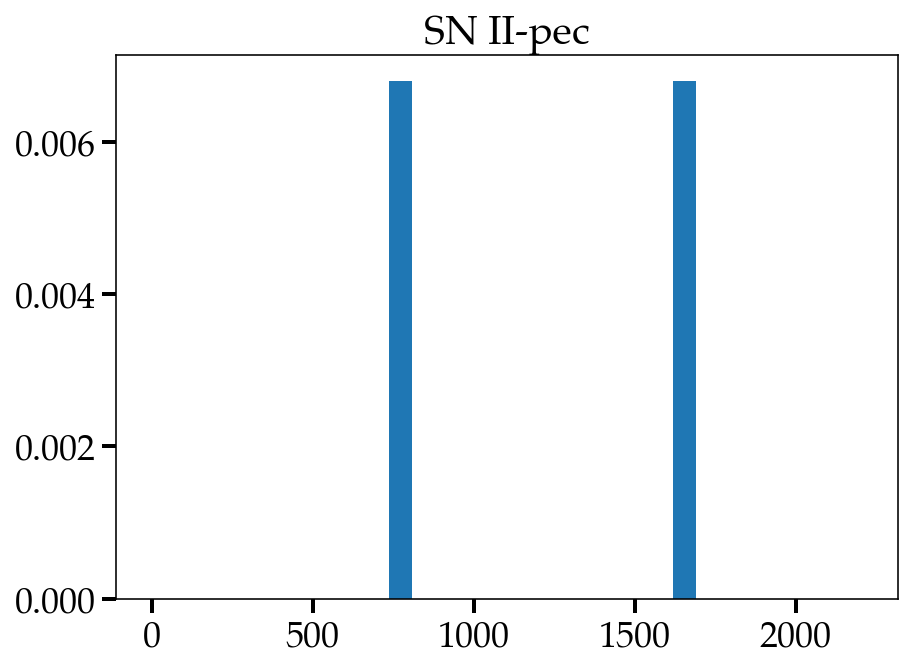

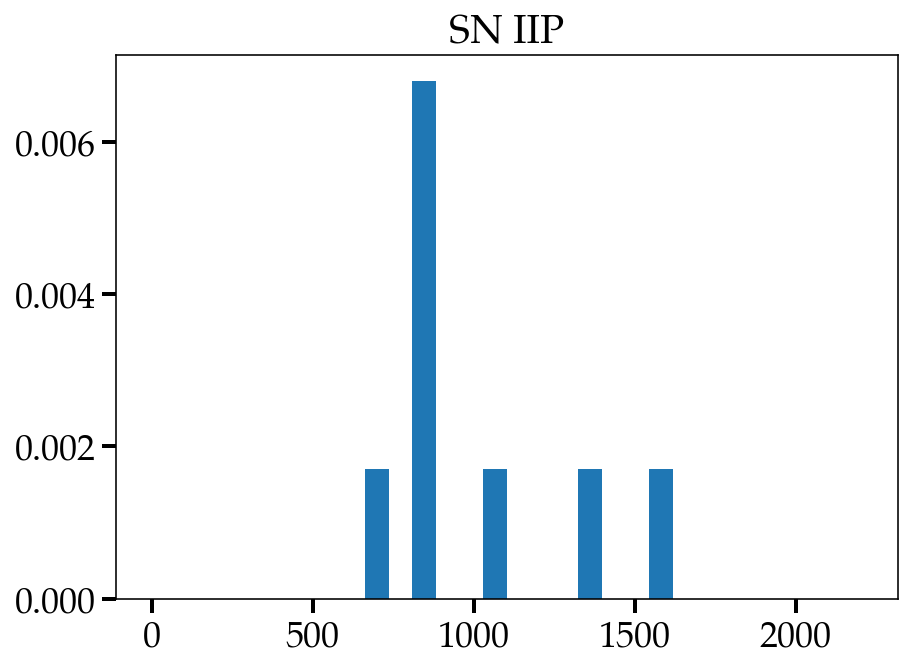

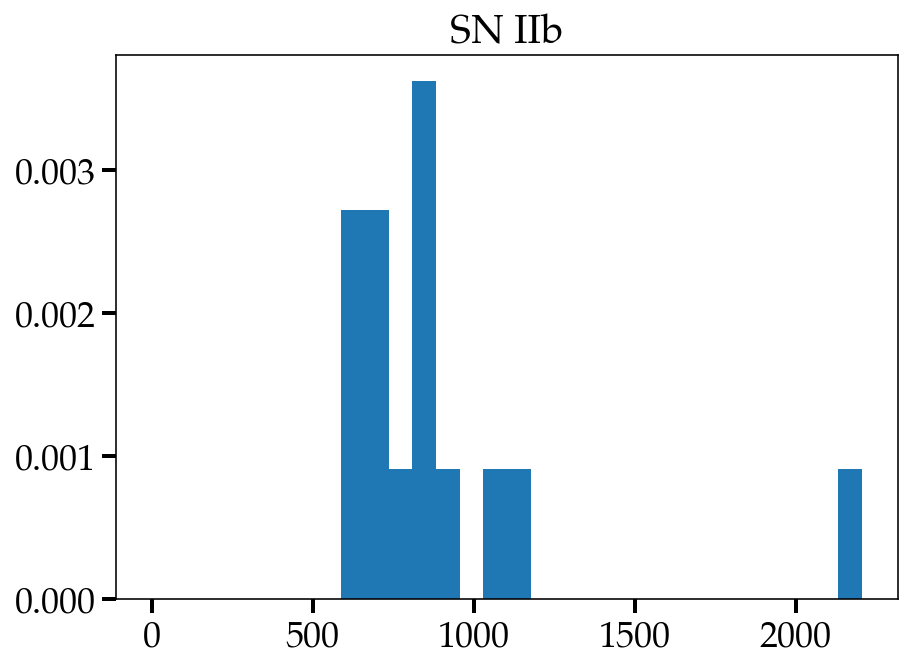

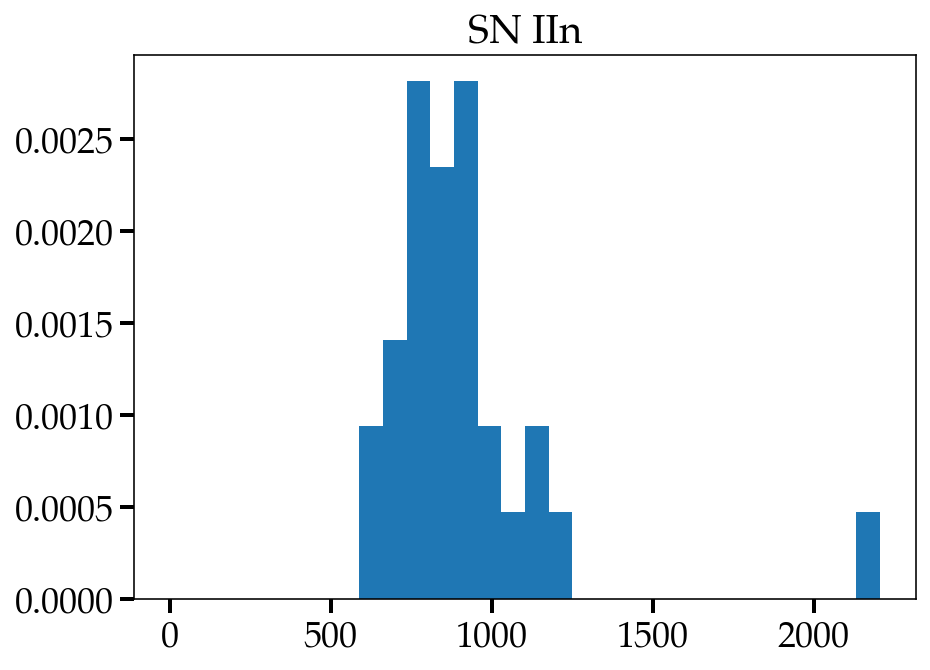

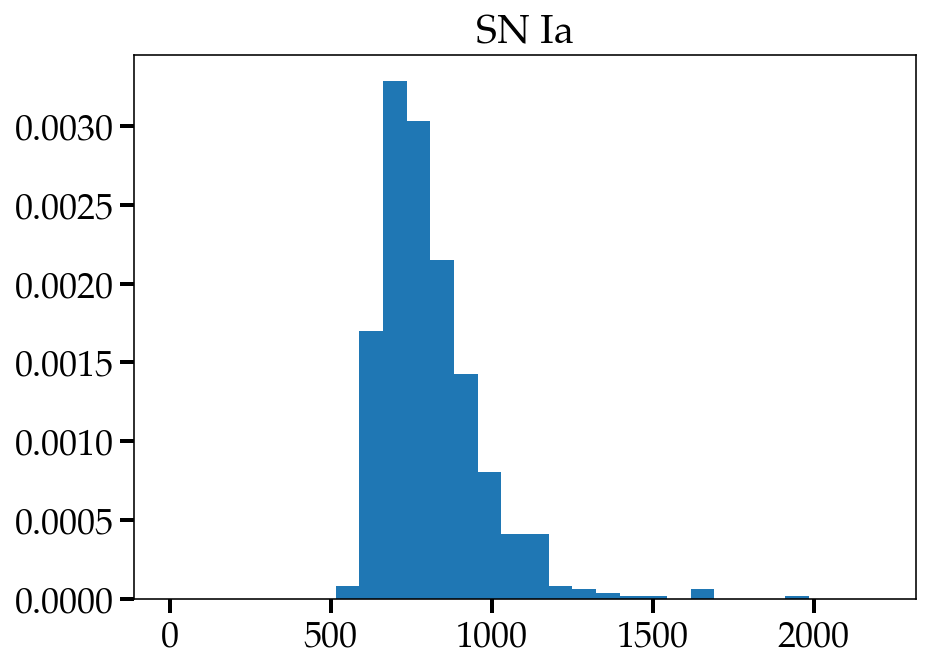

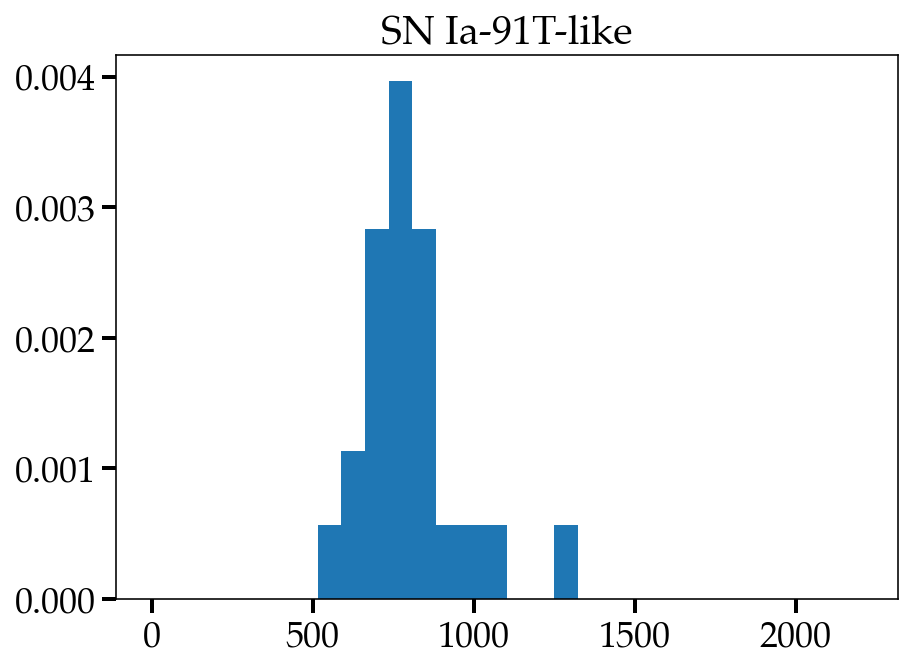

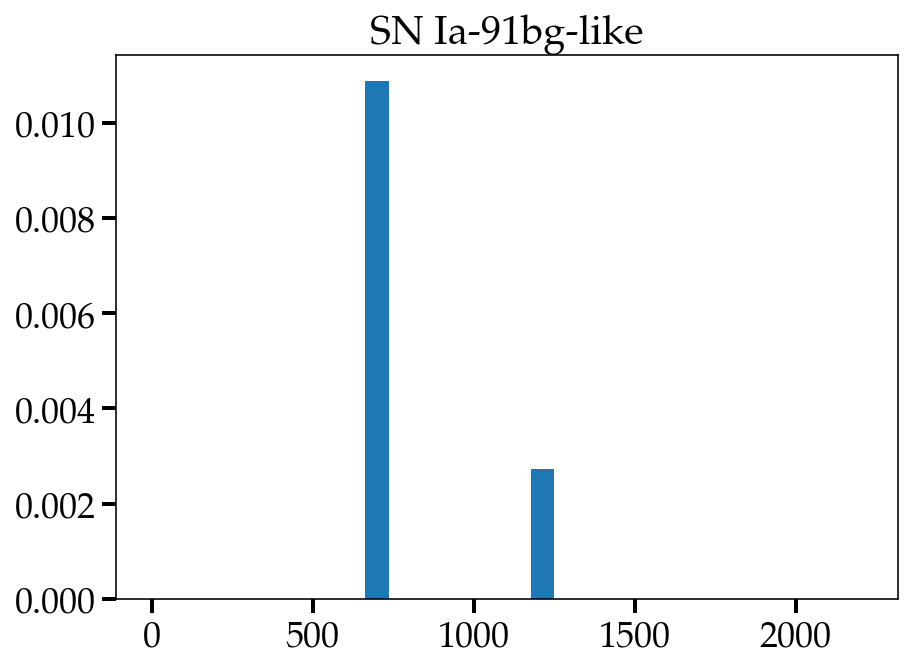

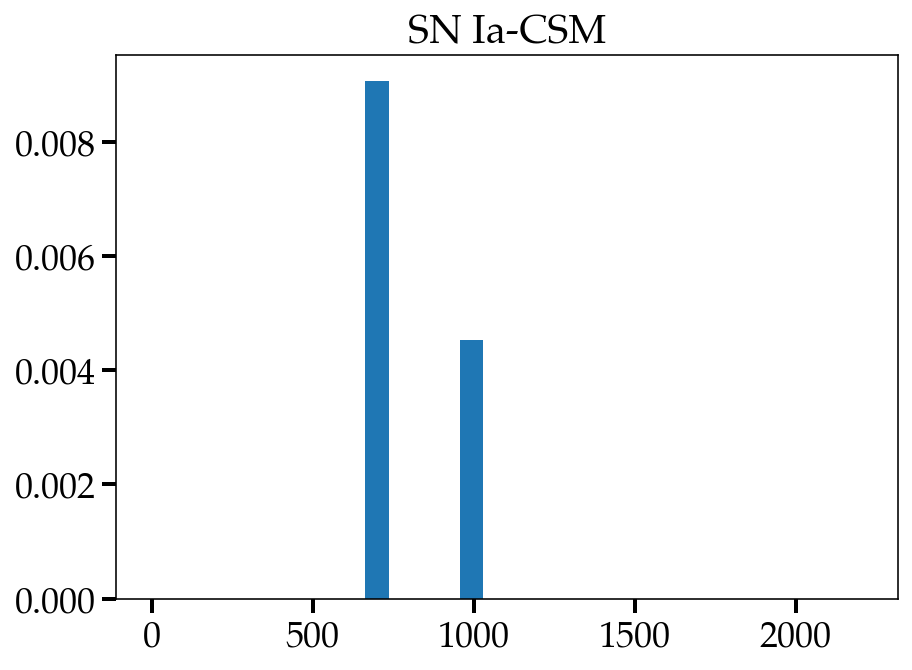

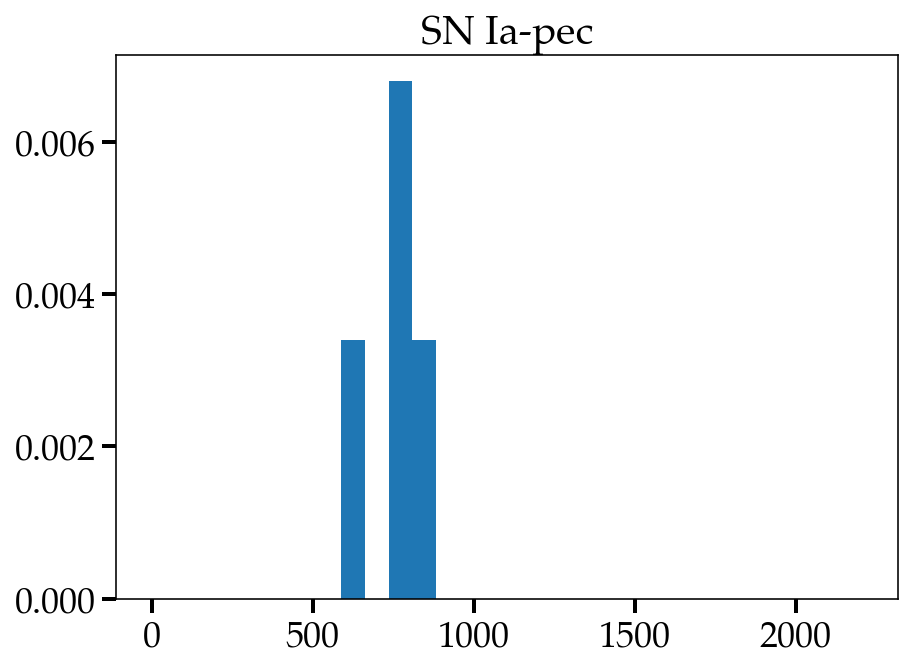

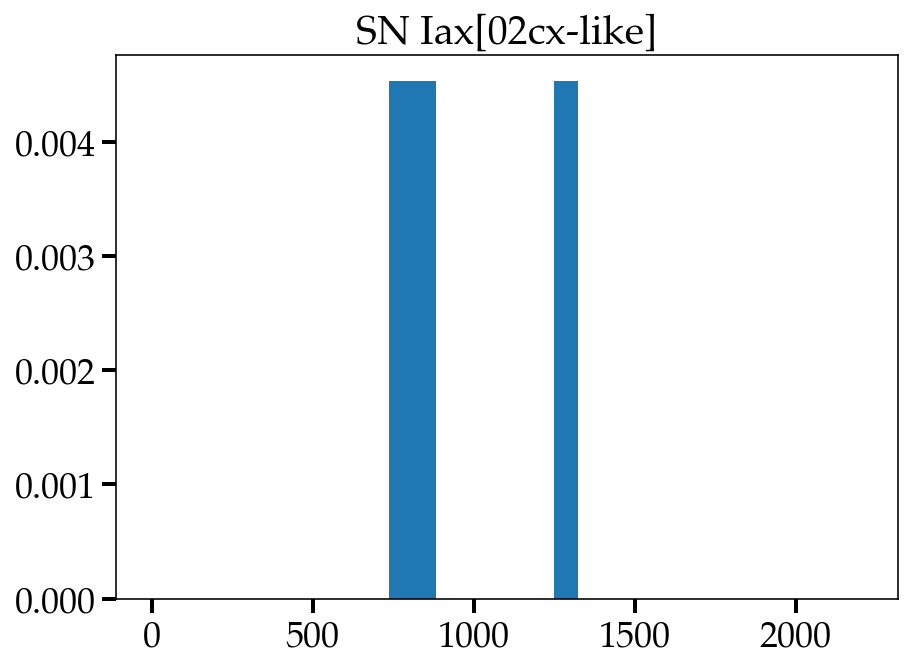

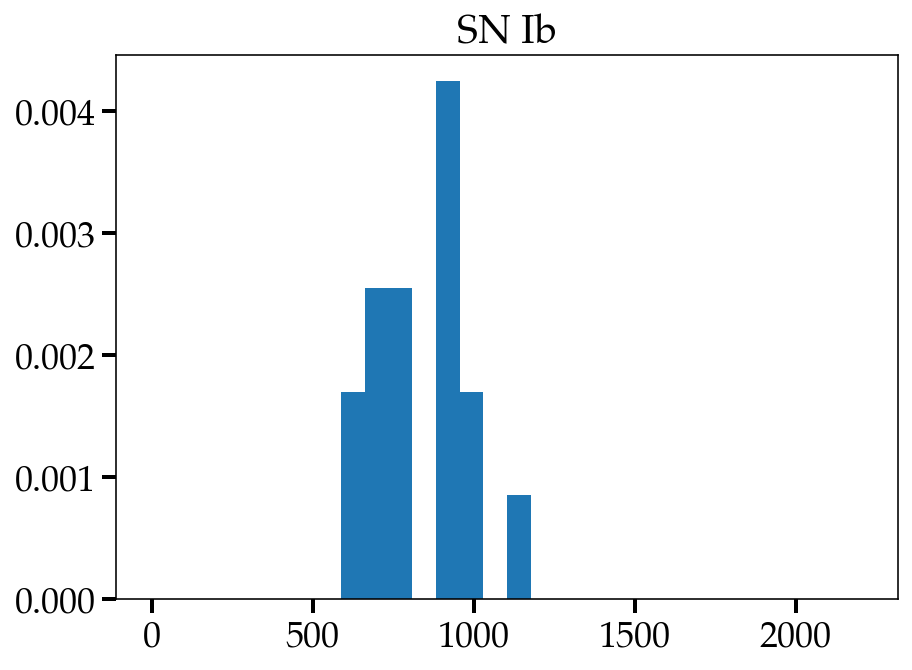

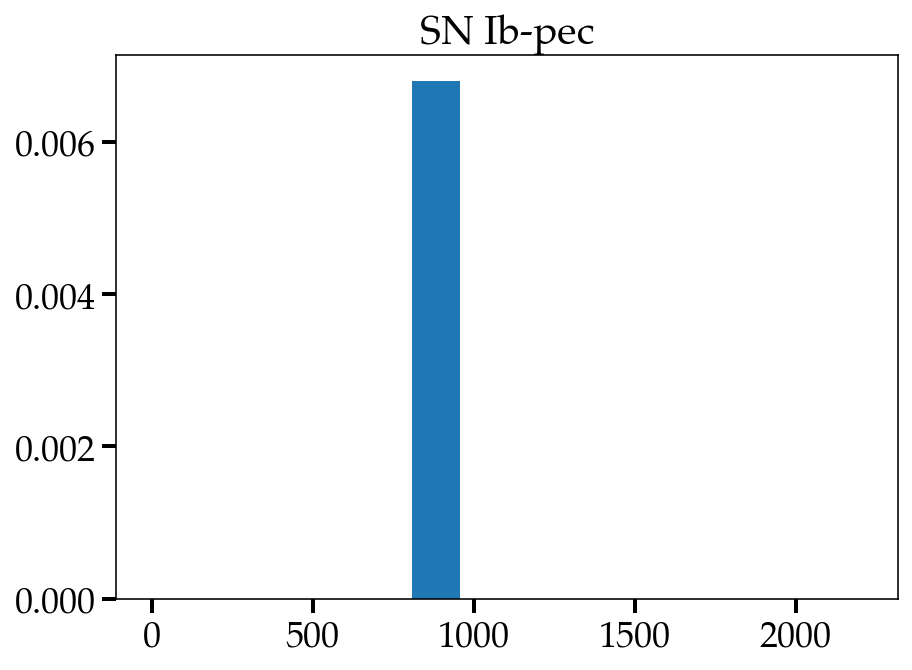

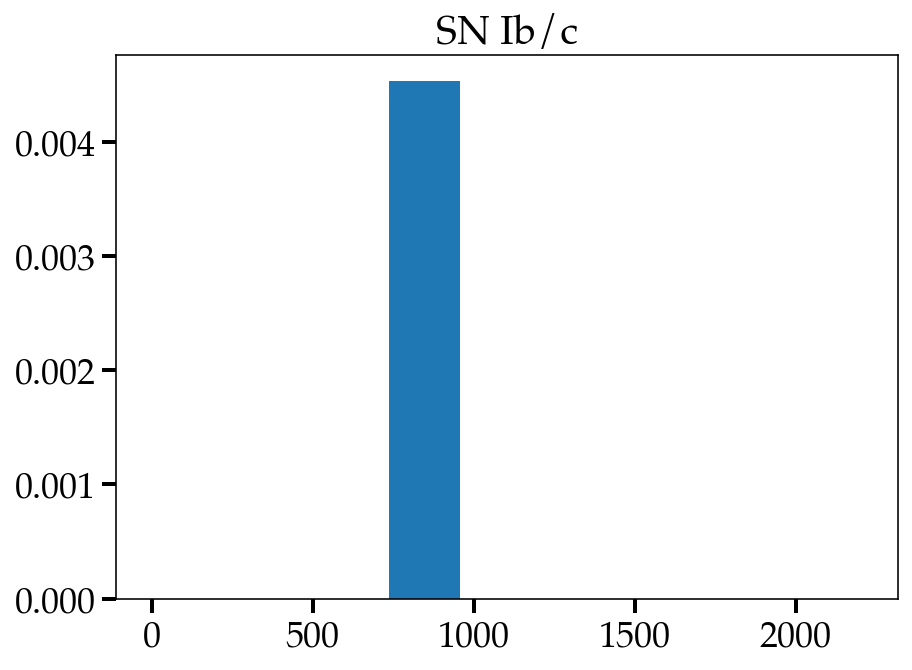

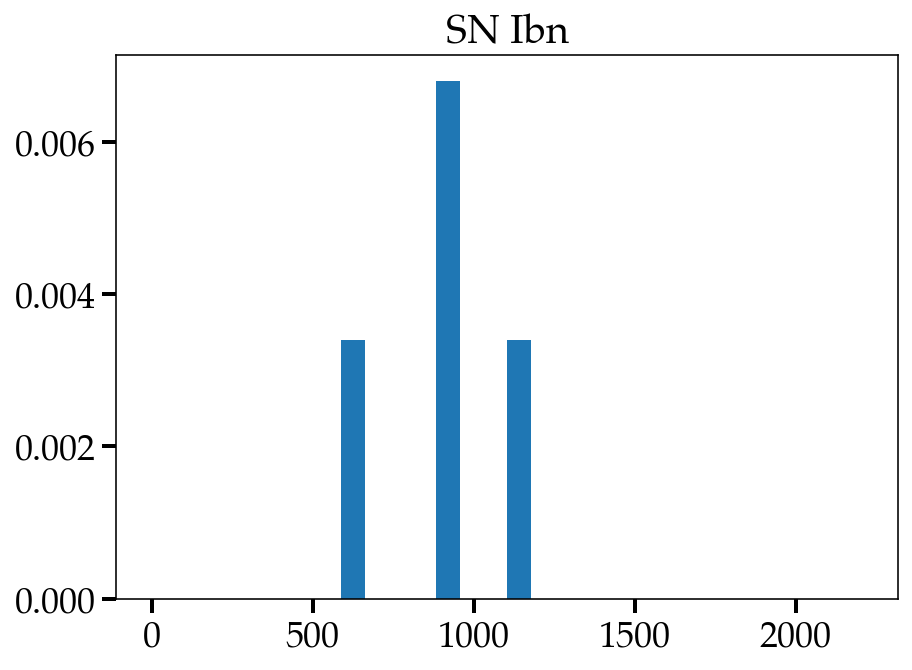

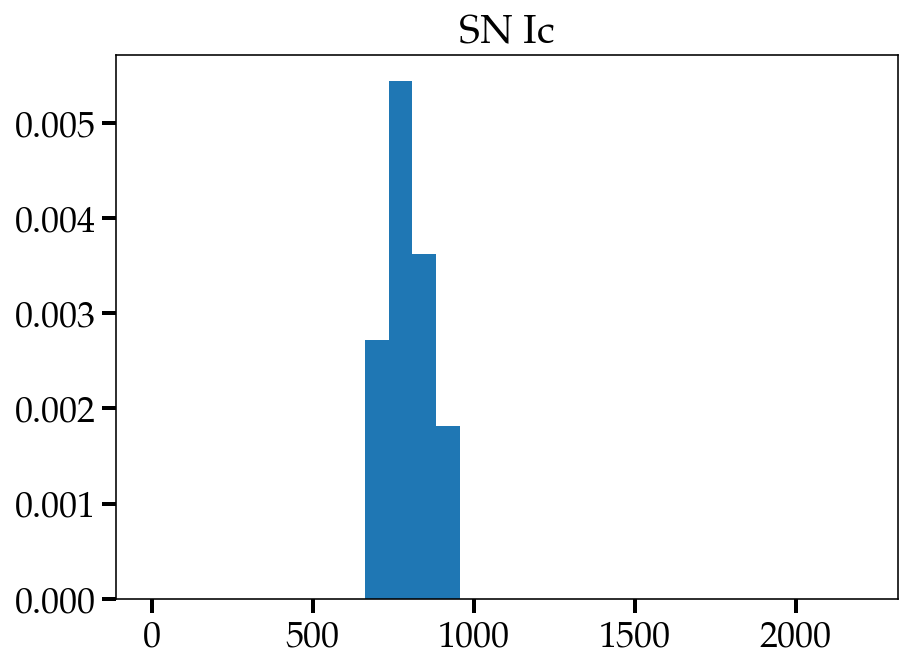

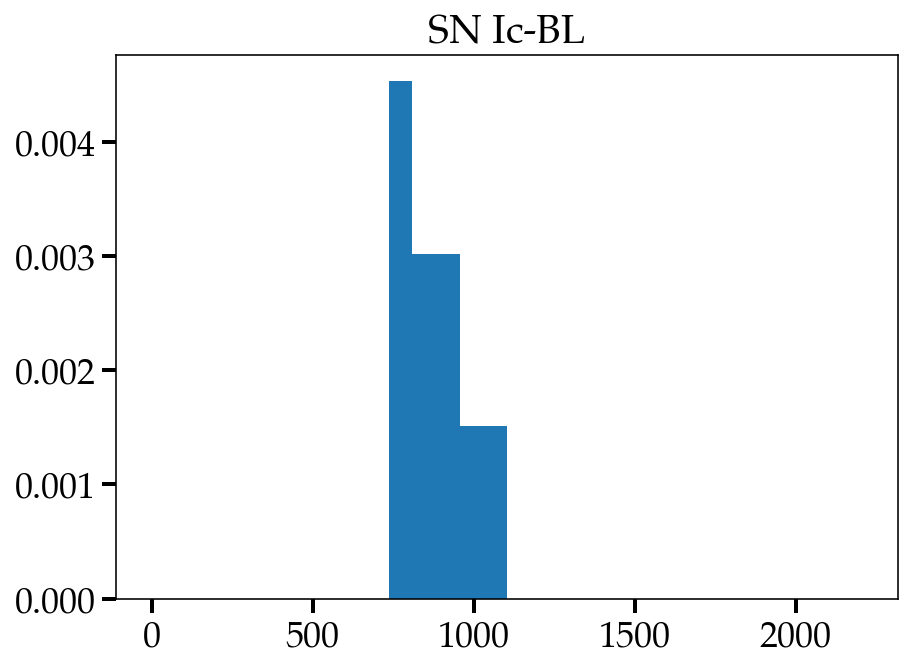

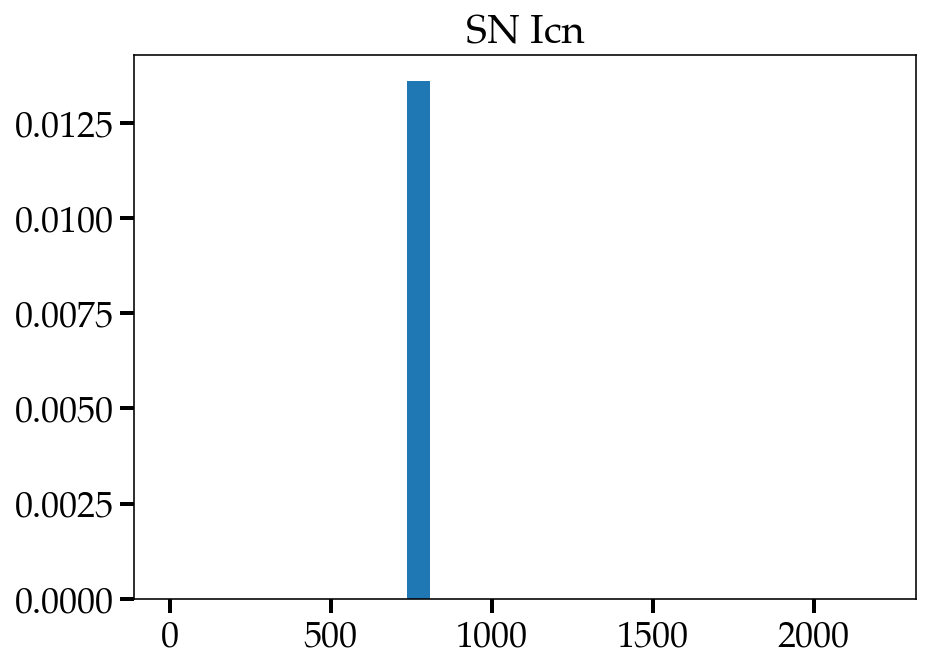

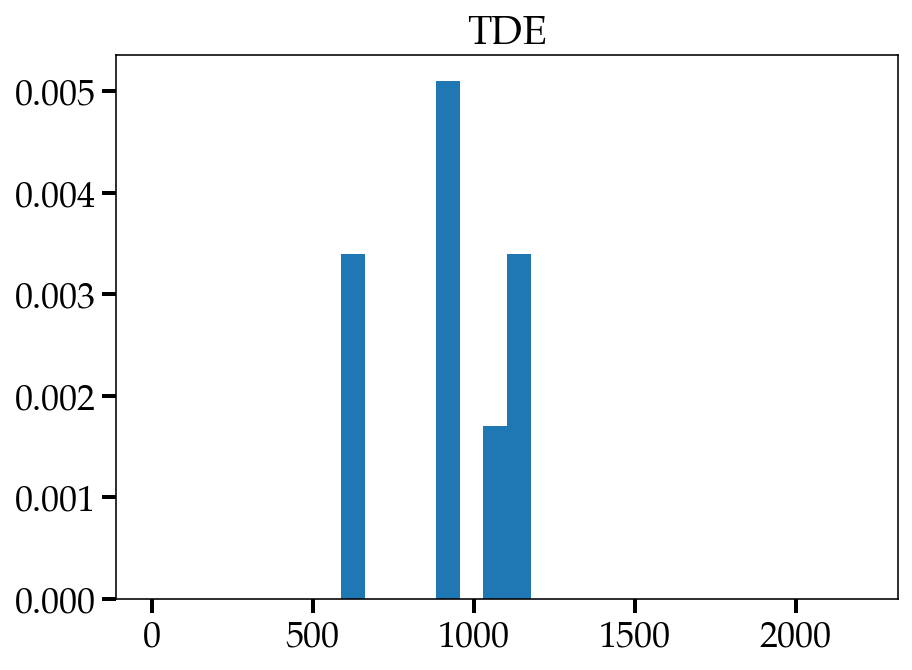

In [6]:
for cls in np.unique(merge_df.tns_cls):
    fig, ax = plt.subplots()
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, np.max(merge_df["WeightedMean-9ANNs"]), 31), density=True)
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(0, np.max(merge_df[dist_col]), 31), density=True)
    
    ax.set_title(cls)
    #ax.set_xlim(0, 150)

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


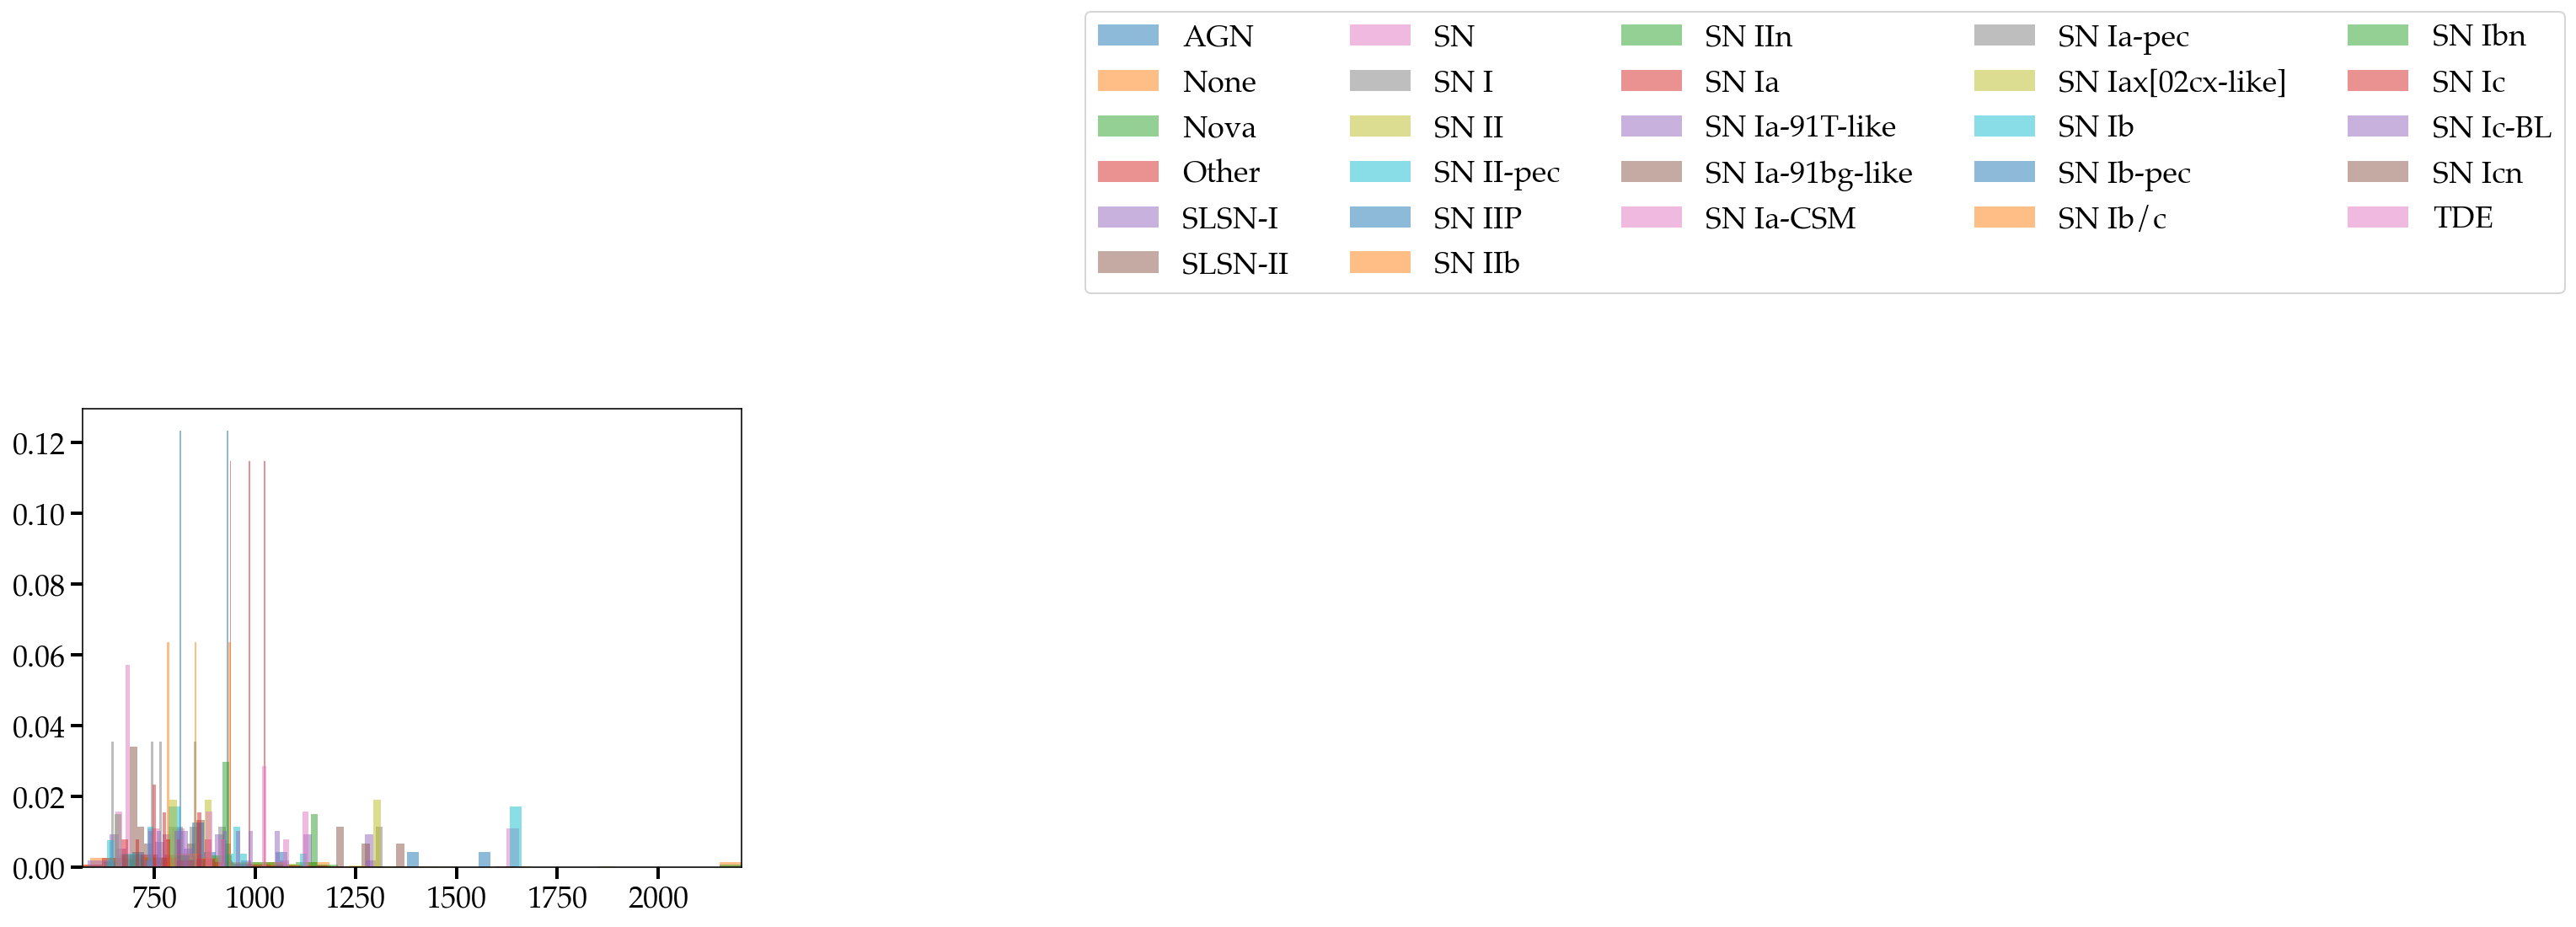

In [7]:
fig, ax = plt.subplots()

for cls in np.unique(merge_df.tns_cls):
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, 150, 31), 
    #        density=True, alpha=0.5, label=cls)
    
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(np.min(merge_df_cls[dist_col]), np.max(merge_df_cls[dist_col]), 31), 
            density=True, alpha=0.5, label=cls)
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.legend(ncol=5, bbox_to_anchor=(1.5,1.9))

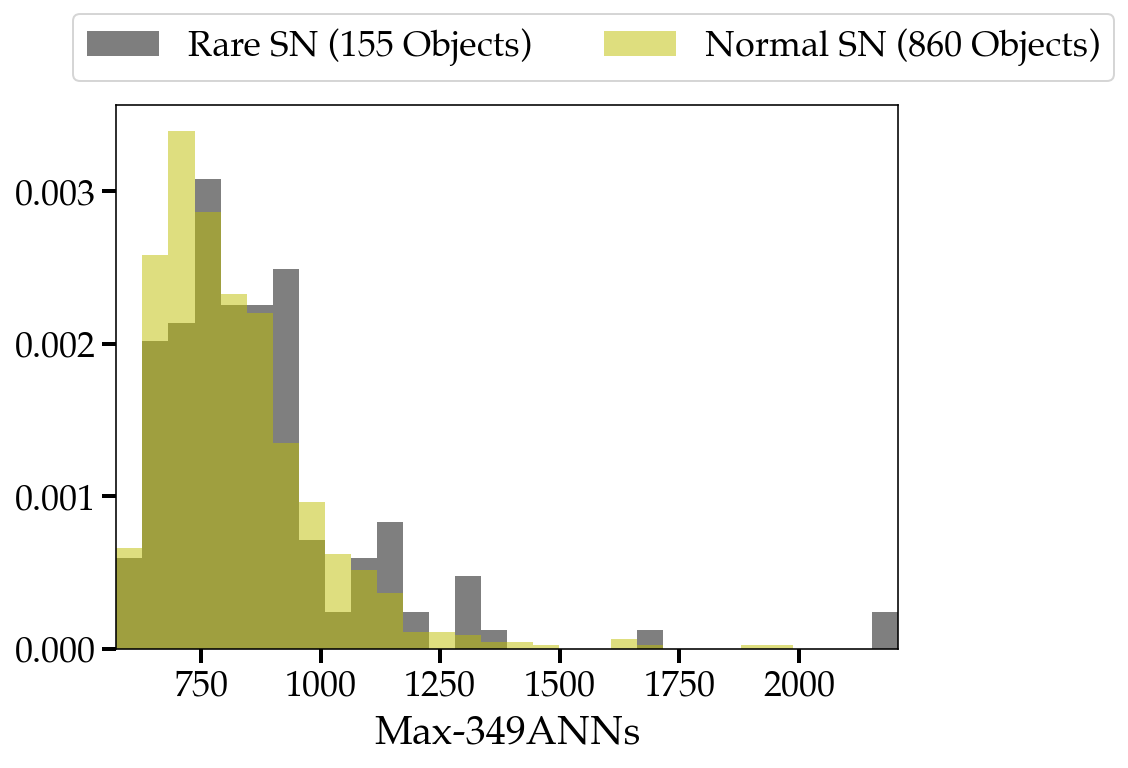

In [8]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
#plt.xscale('log')
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}.png')
plt.show()

In [9]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test

# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df[dist_col], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df[dist_col], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.14838709677419354
P-value: 0.1465300512255596
The two distributions are likely the same.


In [10]:
np.median(normal_sn_df[dist_col])

784.6268615722656

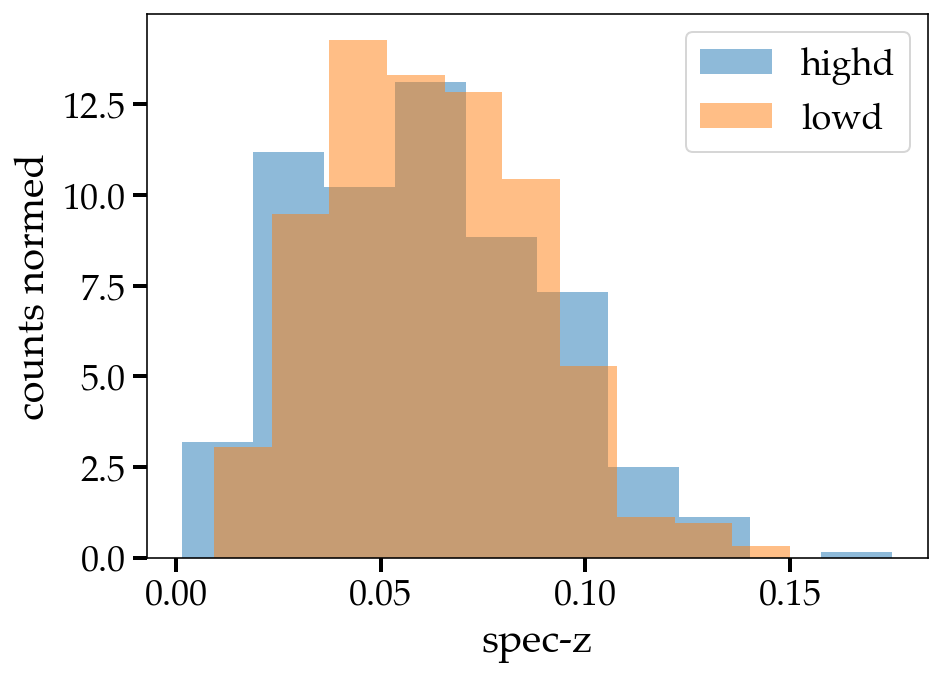

In [12]:
normal_sn_highd_df = normal_sn_df[normal_sn_df[dist_col] >= 790]
normal_sn_lowd_df = normal_sn_df[normal_sn_df[dist_col] <= 790]

plt.hist(normal_sn_highd_df.spec_z, alpha=0.5, density=True, label='highd')
plt.hist(normal_sn_lowd_df.spec_z, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [13]:
len(normal_sn_highd_df)

417

In [14]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_lowd_df.spec_z, size=len(normal_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.09352517985611511
P-value: 0.054667765395492195
The two distributions are likely the same.


In [15]:
np.median(rare_sn_df[dist_col])

825.0670776367188

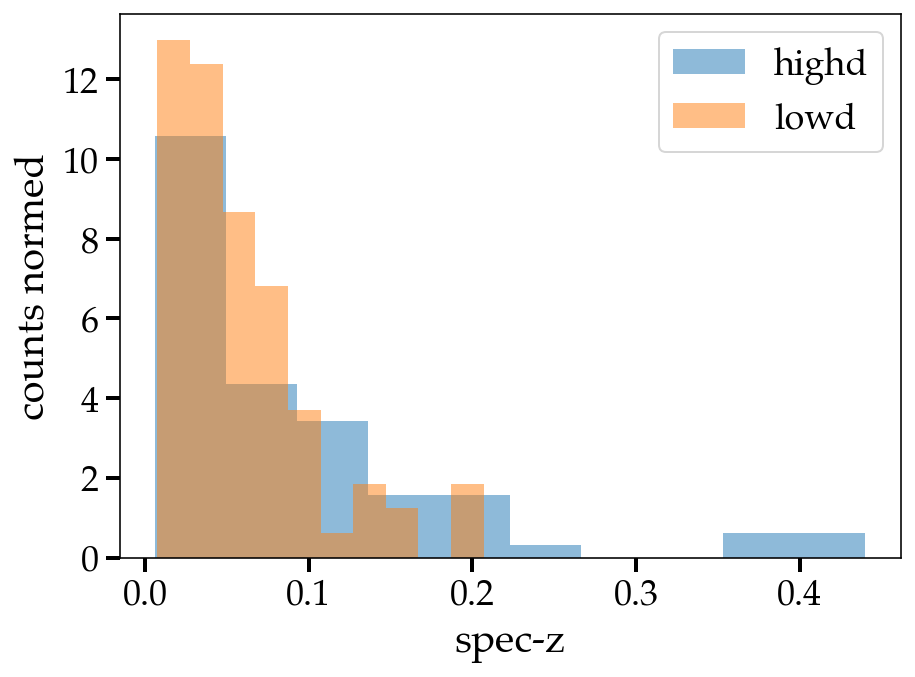

In [16]:
rare_sn_highd_df = rare_sn_df[rare_sn_df[dist_col] >= 830]
rare_sn_lowd_df = rare_sn_df[rare_sn_df[dist_col] <= 830]

plt.hist(rare_sn_highd_df.spec_z, alpha=0.5, density=True, label='highd')
plt.hist(rare_sn_lowd_df.spec_z, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [17]:
len(rare_sn_lowd_df)

81

In [18]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_sn_lowd_df.spec_z, size=len(rare_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.22972972972972974
P-value: 0.08983308126013523
The two distributions are likely the same.


fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('Mean-49ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_Mean.png')
plt.show()

from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df["Mean-49ANNs"], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df["Mean-49ANNs"], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

## No statistical difference between Rare SN and Normal SN 

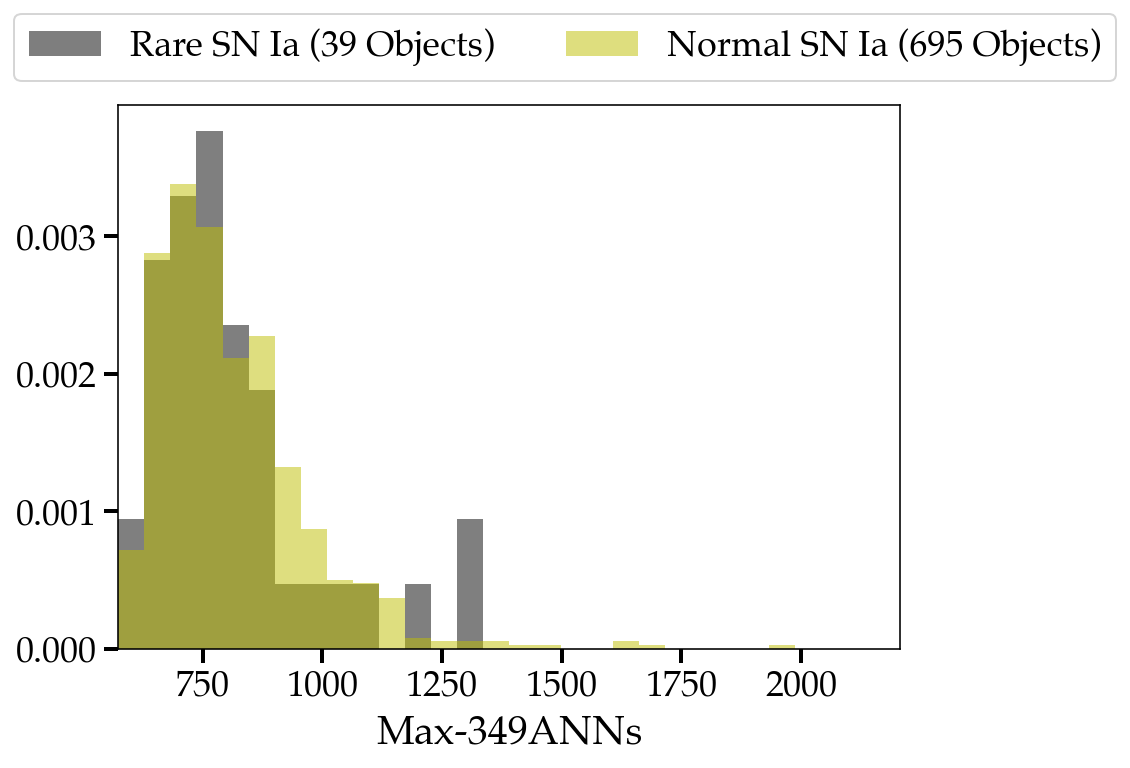

In [19]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_snIa_l = ['SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM', 'SN Ia-pec', 'SN Iax[02cx-like]']
rare_snIa_df = merge_df[merge_df.tns_cls.isin(rare_snIa_l)]
ax.hist(rare_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN Ia ({len(rare_snIa_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_snIa_l = ['SN Ia']
normal_snIa_df = merge_df[merge_df.tns_cls.isin(normal_snIa_l)]
ax.hist(normal_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN Ia ({len(normal_snIa_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}_Ia.png')
plt.show()

In [20]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_snIa_subsample = np.random.choice(normal_snIa_df[dist_col], size=len(rare_snIa_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_df[dist_col], normal_snIa_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.1282051282051282
P-value: 0.722227528191703
The two distributions are likely the same.


## No statistical difference between Rare SN Ia and Normal SN Ia...

In [21]:
np.median(normal_snIa_df[dist_col])

770.220703125

In [22]:
normal_snIa_highd_df = normal_snIa_df[normal_snIa_df[dist_col] >= 775]
normal_snIa_lowd_df = normal_snIa_df[normal_snIa_df[dist_col] <= 775]

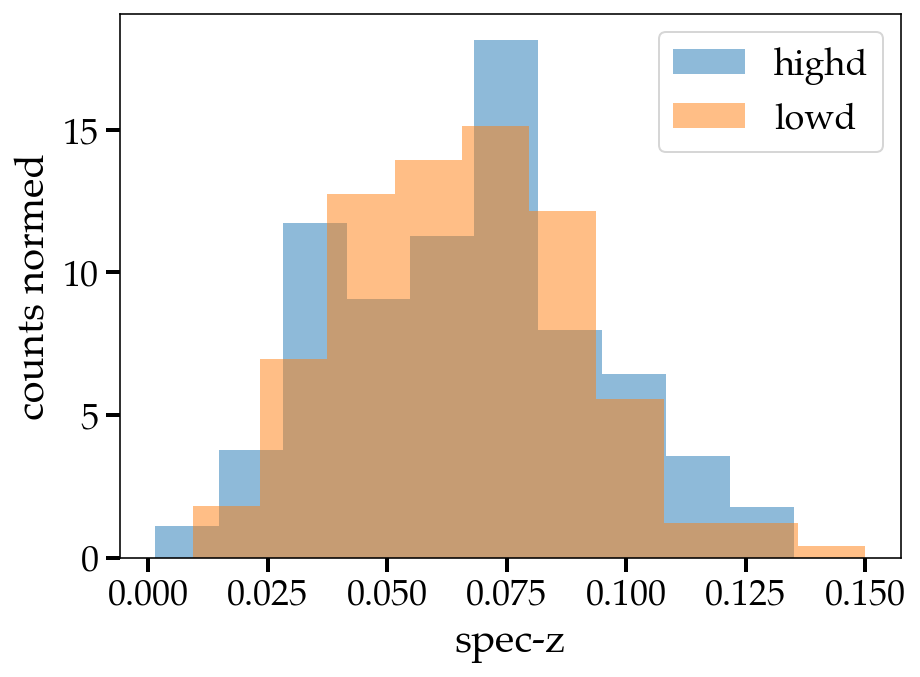

In [23]:
plt.hist(normal_snIa_highd_df.spec_z, alpha=0.5, density=True, label='highd')
plt.hist(normal_snIa_lowd_df.spec_z, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [24]:
normal_snIa_highd_df.spec_z

ztf_object_id
ZTF18aahfbqp    0.041362
ZTF18aaisqmw    0.052700
ZTF18aajjhkq    0.070000
ZTF18acaucsw    0.070000
ZTF18acbuibx    0.060000
                  ...   
ZTF21abzkgvc    0.098000
ZTF21acafsjy    0.097000
ZTF21accuexh    0.072000
ZTF21acenkuf    0.012319
ZTF21ackbbfs    0.045000
Name: spec_z, Length: 338, dtype: float64

In [25]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_snIa_lowd_df.spec_z, size=len(normal_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.0621301775147929
P-value: 0.48537506135809855
The two distributions are likely the same.


In [26]:
np.median(rare_snIa_df[dist_col])

763.8304443359375

In [28]:

rare_snIa_highd_df = rare_snIa_df[rare_snIa_df[dist_col] >= 770]
rare_snIa_lowd_df = rare_snIa_df[rare_snIa_df[dist_col] <= 770]

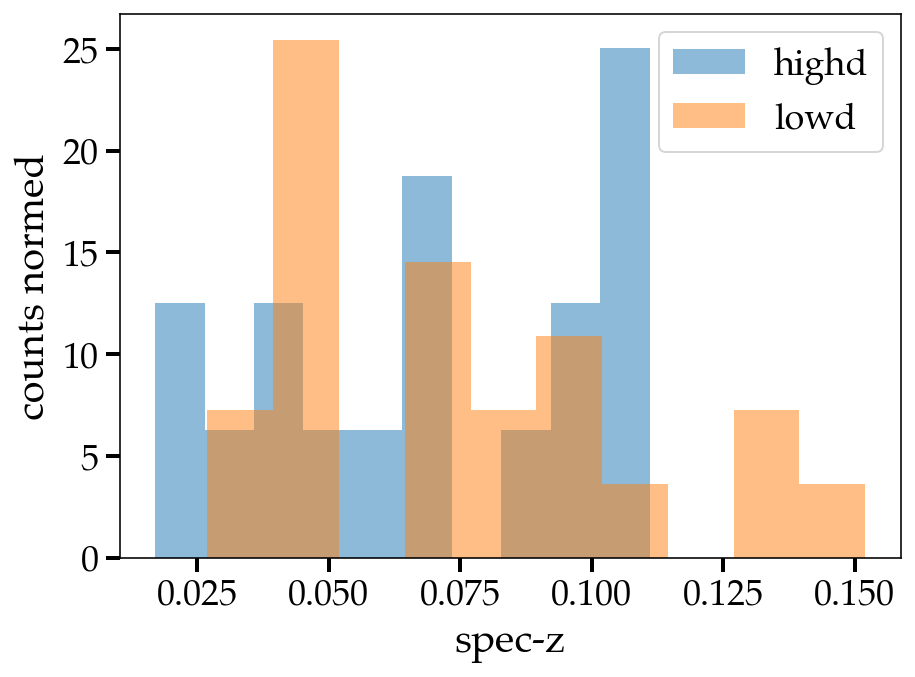

In [29]:
plt.hist(rare_snIa_highd_df.spec_z, alpha=0.5, density=True, label='highd')
plt.hist(rare_snIa_lowd_df.spec_z, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [30]:
len(rare_snIa_highd_df)

17

In [31]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_snIa_lowd_df.spec_z, size=len(rare_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.17647058823529413
P-value: 0.8184250423998272
The two distributions are likely the same.


# Objs w/ high distances ANNs are Bright/closeby (generally...)
# TODO: how to define "rare"? --> Closeby & bright or rare phenomenology or ???
# Maybe "normalize out" brightness to focus on truly rare SN classes/types/ LCs?

# UPDATED: brightness CAN be normalized out (w/ l1 norm and MI_classif), but tradeoff between good similarity (and host galaxy). If host gal weights all = 0.008 (1/120), then sim is good but high d and low d correspond to low z and high z, respectively. However, if I don't overweight hosts, sim search is not as good but high d and low d DO NOT correspond to low z and high z. So high d and low d objects are not dependent on redshift! But still no diff between rare SN and normal SN ... :( ?

# L1 norm & MI_classif (+changes) normalizes brightness ANN d but not great at AD, but Standard Scaler & MI_classif (+changes) is good at Sim Search, but not great at AD. What is great at AD if features overlap??? Try other scalers?

In [32]:
# rare b/c closeby and bright or dust extincted or lc on decline

for snia in normal_snIa_highd_df.index:
    print(f'https://alerce.online/object/{snia}')

https://alerce.online/object/ZTF18aahfbqp
https://alerce.online/object/ZTF18aaisqmw
https://alerce.online/object/ZTF18aajjhkq
https://alerce.online/object/ZTF18acaucsw
https://alerce.online/object/ZTF18acbuibx
https://alerce.online/object/ZTF18acbvgtu
https://alerce.online/object/ZTF18acbygcu
https://alerce.online/object/ZTF18acbyyff
https://alerce.online/object/ZTF18acptgzz
https://alerce.online/object/ZTF18acsohut
https://alerce.online/object/ZTF18acsovsw
https://alerce.online/object/ZTF20aatxryt
https://alerce.online/object/ZTF20abeywdn
https://alerce.online/object/ZTF20abptxls
https://alerce.online/object/ZTF20abqfgee
https://alerce.online/object/ZTF20abqvsik
https://alerce.online/object/ZTF20absvtnc
https://alerce.online/object/ZTF20abvowvw
https://alerce.online/object/ZTF20abvyauy
https://alerce.online/object/ZTF20abxyajd
https://alerce.online/object/ZTF20abygigy
https://alerce.online/object/ZTF20abylbuf
https://alerce.online/object/ZTF20abyvtds
https://alerce.online/object/ZTF20

In [33]:
rare_snIa_df[rare_snIa_df[dist_col] >= 200]

,Mean-349ANNs,Max-349ANNs,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,
ZTF18aafzers,544.218722,643.132690,Yes_TNS,SN Ia-pec,0.048708,ALeRCE
ZTF18aarindm,602.942664,711.896606,Yes_TNS,SN Ia-91T-like,0.097000,ATLAS
ZTF20abbbsfs,570.055412,678.714172,Yes_TNS,SN Ia-CSM,0.136000,ATLAS
ZTF20abmlxrx,578.430345,682.870544,Yes_TNS,SN Ia-CSM,0.095000,ATLAS
ZTF20abqkbfx,873.108853,1028.404175,Yes_TNS,SN Ia-CSM,0.096400,ZTF
ZTF20abwrcmq,1133.220847,1312.019897,Yes_TNS,SN Iax[02cx-like],0.017000,ZTF
ZTF20acbttnt,653.848064,760.076355,Yes_TNS,SN Ia-91T-like,0.099000,ZTF
ZTF20acgkuay,983.895088,1219.519287,Yes_TNS,SN Ia-91bg-like,0.048460,SGLF
ZTF20achrklb,561.903545,669.128601,Yes_TNS,SN Ia-91T-like,0.070000,ALeRCE


## TODO: find a new method for really Rare SN!
## TODO: Also, find if Rare SN--> Rare SN and Normal SN --> Normal SN

In [34]:
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after"
#suffix="hasTNS-spec_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"
#suffix="hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"

full_ann_properties_df = pd.read_csv(f'../dataframes/full_ann_properties_df_{suffix}.csv', index_col=0)
full_ann_properties_df

,ann=0_ztfid,ann=1_ztfid,ann=2_ztfid,ann=3_ztfid,ann=4_ztfid,ann=5_ztfid,ann=6_ztfid,ann=7_ztfid,ann=8_ztfid,ann=9_ztfid,...,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z
0,ZTF17aaahrni,ZTF21abctgsv,ZTF18acrhegn,ZTF21aazqmfh,ZTF21aapjzfm,ZTF21accqlsf,ZTF20acteioa,ZTF18absljlb,ZTF19abkdcxv,ZTF21aazenvp,...,-99.000,-99.000,-99.0000,-99.000,-99.000000,-99.0,-99.00000,-99.0,-99.000,-99.0000
1,ZTF17aadqidc,ZTF21acimaio,ZTF21aarigez,ZTF21abbewsz,ZTF20abkqmeq,ZTF21abskbhi,ZTF21aaprfkc,ZTF18acrxnme,ZTF19aaajbmv,ZTF21aaribeh,...,-99.000,-99.000,-99.0000,0.075,-99.000000,-99.0,0.05600,-99.0,-99.000,-99.0000
2,ZTF18aabdnbr,ZTF20acuhgar,ZTF21aavrvuj,ZTF20acyxomd,ZTF20achbejn,ZTF20aculrpj,ZTF21aareeiq,ZTF21aayywal,ZTF21abfuynz,ZTF21aarxuih,...,-99.000,0.053,0.0640,-99.000,0.040000,-99.0,-99.00000,-99.0,-99.000,-99.0000
3,ZTF18aabeszt,ZTF20acqtaiq,ZTF19aaajcbb,ZTF21aagsceu,ZTF20accrkpa,ZTF21abvypkt,ZTF21aawlwoy,ZTF21aalyhal,ZTF21aapkbeu,ZTF20acgcgnf,...,0.081,-99.000,-99.0000,-99.000,0.081000,-99.0,0.05032,-99.0,-99.000,0.0960
4,ZTF18aabvmws,ZTF18aakeanj,ZTF21abgxudc,ZTF21aaaollj,ZTF21aagmryd,ZTF21aaostqr,ZTF20acpeyoo,ZTF20acotzqi,ZTF20acojxtb,ZTF18aayyqia,...,-99.000,-99.000,0.0264,-99.000,0.027489,-99.0,-99.00000,-99.0,0.050,0.0691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3623,ZTF21ackmpcb,ZTF21abecoyv,ZTF21acldmwy,ZTF21aatjbrl,ZTF19aaafotc,ZTF21abcnhrd,ZTF18abufwxs,ZTF20abkqmeq,ZTF21abcwnub,ZTF21aazlqij,...,-99.000,-99.000,0.1100,-99.000,-99.000000,-99.0,-99.00000,-99.0,-99.000,-99.0000
3624,ZTF21ackwyaz,ZTF21aagysdv,ZTF20acospqv,ZTF20acowiom,ZTF20acpggtl,ZTF21abcnhrd,ZTF21aatkhrt,ZTF21aayqehn,ZTF21aagtsla,ZTF21aaynopr,...,-99.000,-99.000,-99.0000,-99.000,-99.000000,-99.0,0.12800,-99.0,-99.000,-99.0000
3625,ZTF21ackzfeh,ZTF19aabhqcn,ZTF18acckcfr,ZTF21aayytiz,ZTF20acrxqkg,ZTF21aaygefv,ZTF21aavrywc,ZTF18acvggdb,ZTF21aaweqit,ZTF21aawzkdr,...,-99.000,-99.000,-99.0000,-99.000,-99.000000,-99.0,-99.00000,-99.0,0.060,-99.0000
3626,ZTF21acldmwy,ZTF19aaafotc,ZTF21aaekkso,ZTF21aacuhny,ZTF21ackmpcb,ZTF21aatbcbd,ZTF21abcwnub,ZTF21aadawov,ZTF21acgyzel,ZTF21abnvsic,...,0.110,-99.000,-99.0000,-99.000,-99.000000,-99.0,-99.00000,-99.0,0.049,0.0720


In [35]:
full_ann_tns_cls_df = full_ann_properties_df.iloc[:, 30:40]
full_ann_tns_cls_df

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls
0,None,None,None,None,None,None,None,None,None,None
1,None,None,None,SN Ia,None,None,SN Ia,None,None,None
2,None,SN II,SN II,None,SN II,None,None,None,None,None
3,SN Ia,None,None,None,SN II,None,SN Ia,None,None,SN Ia
4,None,None,SN Ia,None,SN Ia,None,None,None,SN Ia,SN Ia
...,...,...,...,...,...,...,...,...,...,...
3623,None,None,SN Ia,None,None,None,None,None,None,None
3624,None,None,None,None,None,None,SN Ia,None,None,None
3625,None,None,None,None,None,None,None,None,SN II,None
3626,SN Ia,None,None,None,None,None,None,None,SN Ia,SN Ia


In [36]:
full_ann_spec_z_df = full_ann_properties_df.iloc[:, 40:50]
full_ann_spec_z_df

,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z
0,-99.000,-99.000,-99.0000,-99.000,-99.000000,-99.0,-99.00000,-99.0,-99.000,-99.0000
1,-99.000,-99.000,-99.0000,0.075,-99.000000,-99.0,0.05600,-99.0,-99.000,-99.0000
2,-99.000,0.053,0.0640,-99.000,0.040000,-99.0,-99.00000,-99.0,-99.000,-99.0000
3,0.081,-99.000,-99.0000,-99.000,0.081000,-99.0,0.05032,-99.0,-99.000,0.0960
4,-99.000,-99.000,0.0264,-99.000,0.027489,-99.0,-99.00000,-99.0,0.050,0.0691
...,...,...,...,...,...,...,...,...,...,...
3623,-99.000,-99.000,0.1100,-99.000,-99.000000,-99.0,-99.00000,-99.0,-99.000,-99.0000
3624,-99.000,-99.000,-99.0000,-99.000,-99.000000,-99.0,0.12800,-99.0,-99.000,-99.0000
3625,-99.000,-99.000,-99.0000,-99.000,-99.000000,-99.0,-99.00000,-99.0,0.060,-99.0000
3626,0.110,-99.000,-99.0000,-99.000,-99.000000,-99.0,-99.00000,-99.0,0.049,0.0720


In [37]:
# Create Graph df
graph_df = pd.DataFrame()
graph_df['node'] = full_ann_tns_cls_df["ann=0_tns_cls"]

ann_tns_cls_col_list= [f'ann={col}_tns_cls' for col in range(1, 10)]
graph_df['neighbors'] = full_ann_tns_cls_df[ann_tns_cls_col_list].apply(list, axis=1)
graph_df

,node,neighbors
0,None,"[None, None, None, None, None, None, None, Non..."
1,None,"[None, None, SN Ia, None, None, SN Ia, None, N..."
2,None,"[SN II, SN II, None, SN II, None, None, None, ..."
3,SN Ia,"[None, None, None, SN II, None, SN Ia, None, N..."
4,None,"[None, SN Ia, None, SN Ia, None, None, None, S..."
...,...,...
3623,None,"[None, SN Ia, None, None, None, None, None, No..."
3624,None,"[None, None, None, None, None, SN Ia, None, No..."
3625,None,"[None, None, None, None, None, None, None, SN ..."
3626,SN Ia,"[None, None, None, None, None, None, None, SN ..."


In [38]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ibn']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls
1855,SN Ibn,None,None,SN Ia,None,None,None,None,None,None
2062,SN Ibn,SN II,None,None,None,None,None,None,None,None
2213,SN Ibn,None,None,None,SN II,SN Ia,SN Ia,None,SN Ic,SN II
2640,SN Ibn,SN Ia,None,None,None,None,None,None,SN Ia,SN Ia


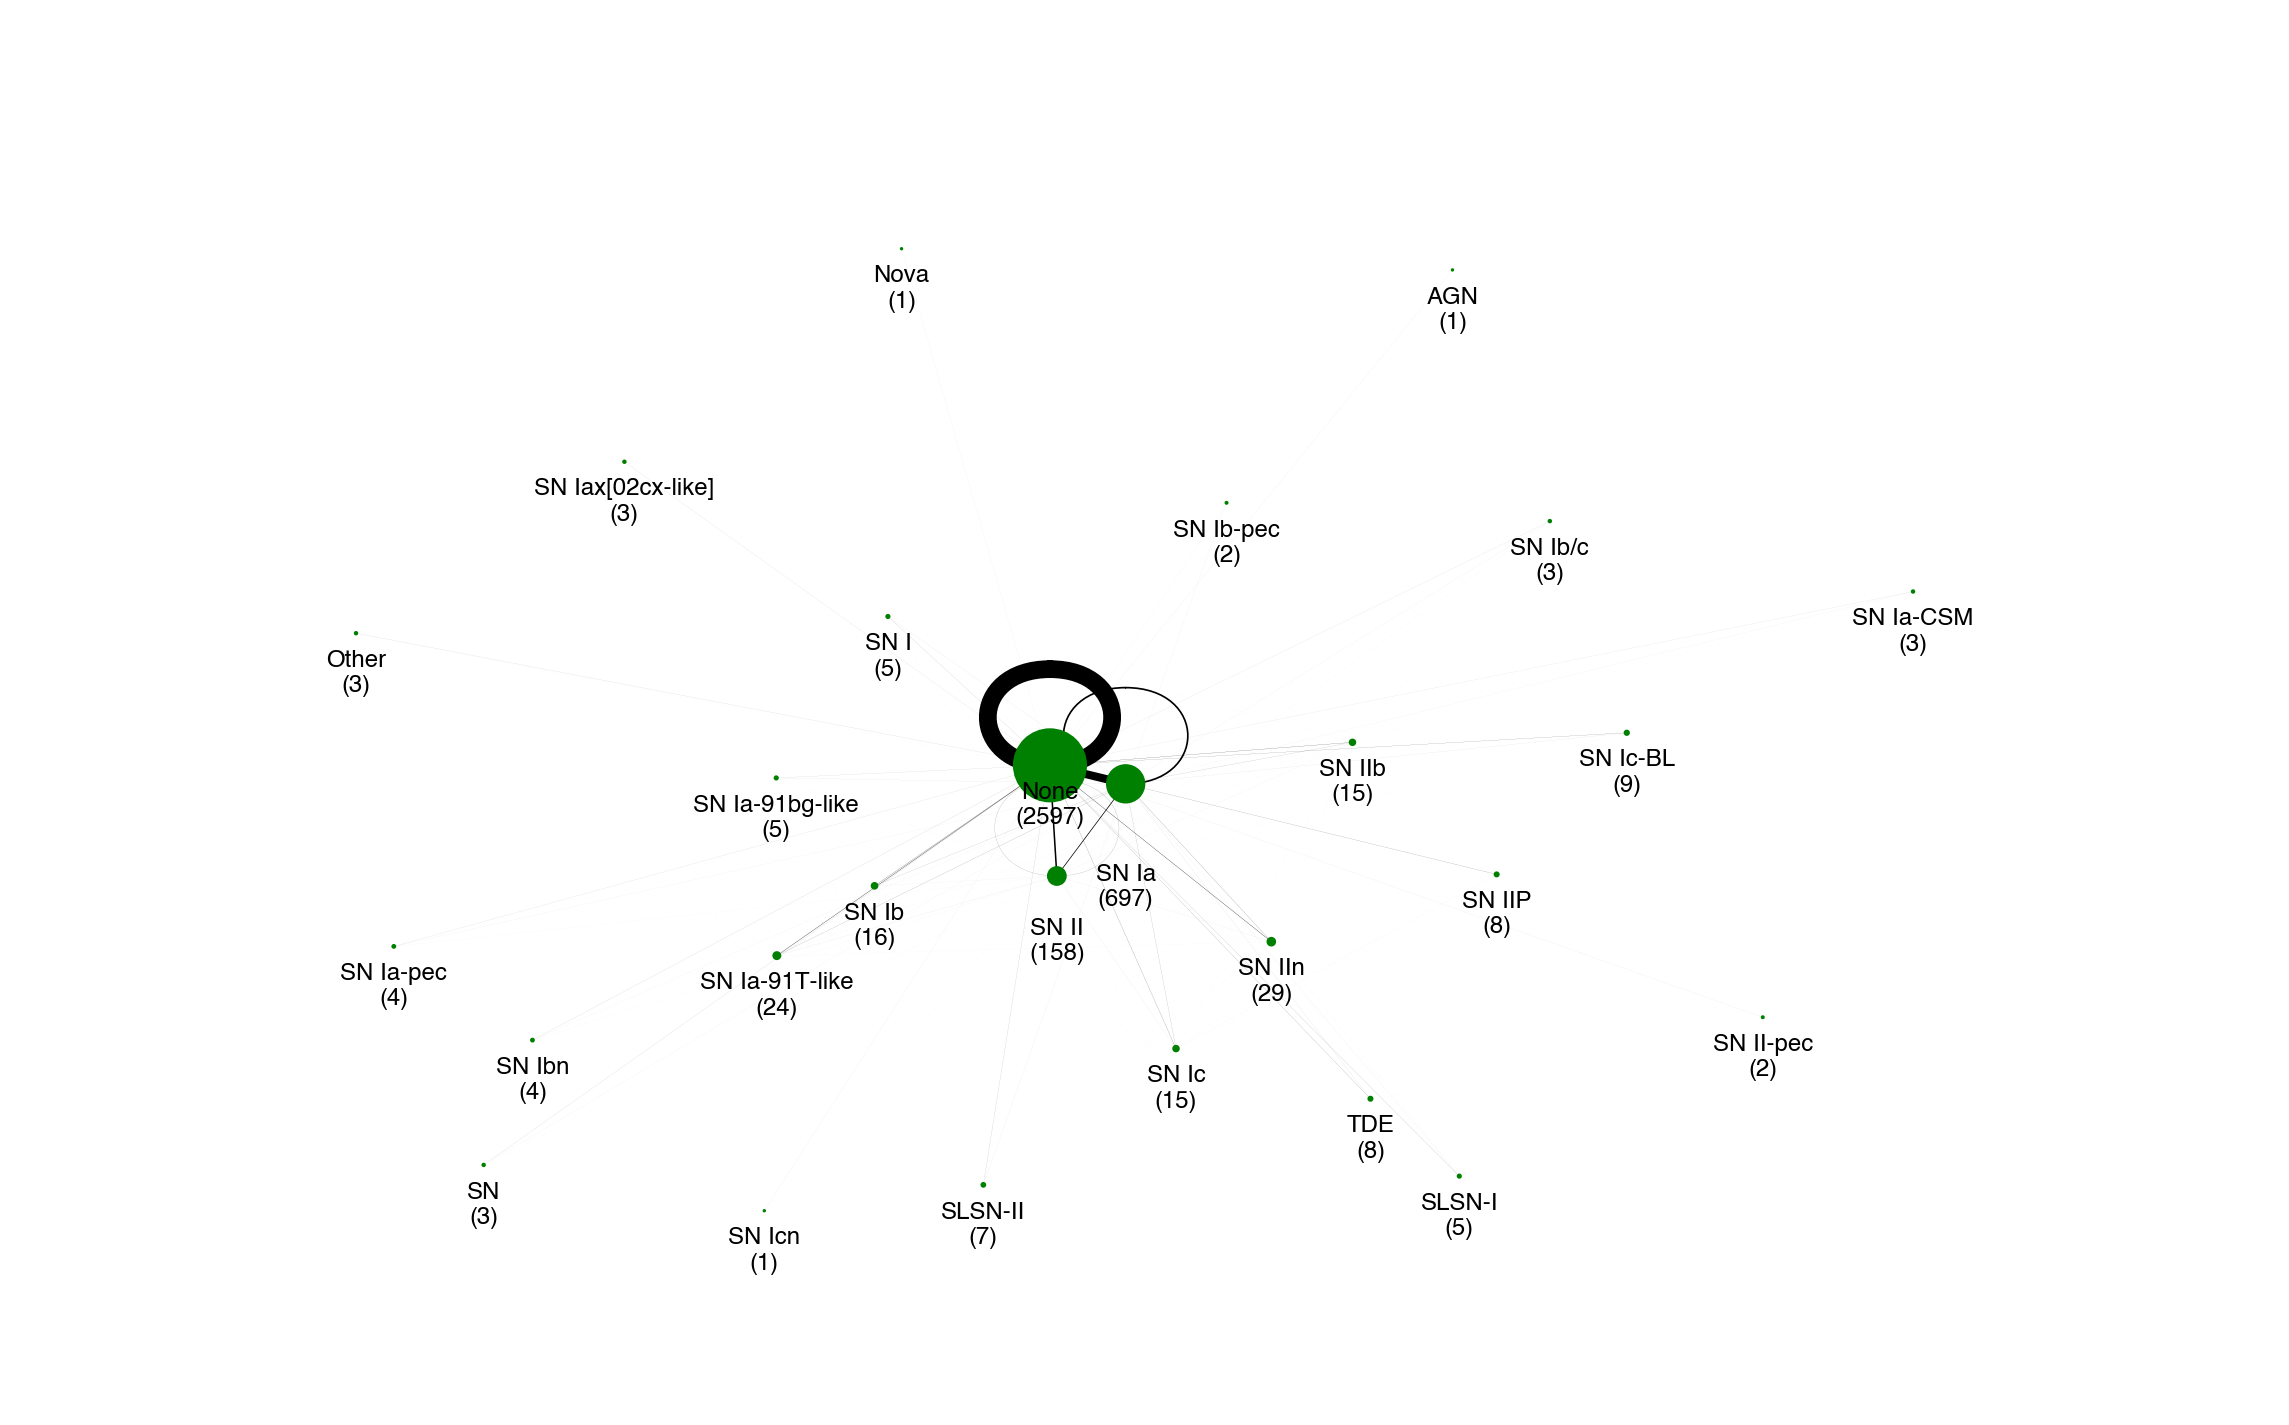

In [39]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Create a sample dataframe with node and edge data
df = graph_df.copy()
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.Graph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/2000 for edge in edge_labels]

node_count = dict(Counter(graph_df['node']))

# Scale the node sizes by the occurrences of the node
#node_sizes = [1.2 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        
node_sizes = [node_count[node] * 0.5 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(16, 10))
nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] - 0.07)
    
# count the number of times of each node 
node_count = dict(Counter(df['node']))

# scale node sizes by frequency
#node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels_d1 = {node: f"{node}\n({node_count[node]})" for node in G.nodes() if node!='SN Ia' and node!='SN II'}
node_labels_d2 = {node: f"\n\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN II'}
node_labels = {node: f"\n\n\n\n\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN Ia'}

node_labels_d2.update(node_labels_d1)
node_labels.update(node_labels_d2)

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
plt.savefig(f'../figures/graphs/{suffix}_size_scaled.jpg', dpi=300)
plt.show()


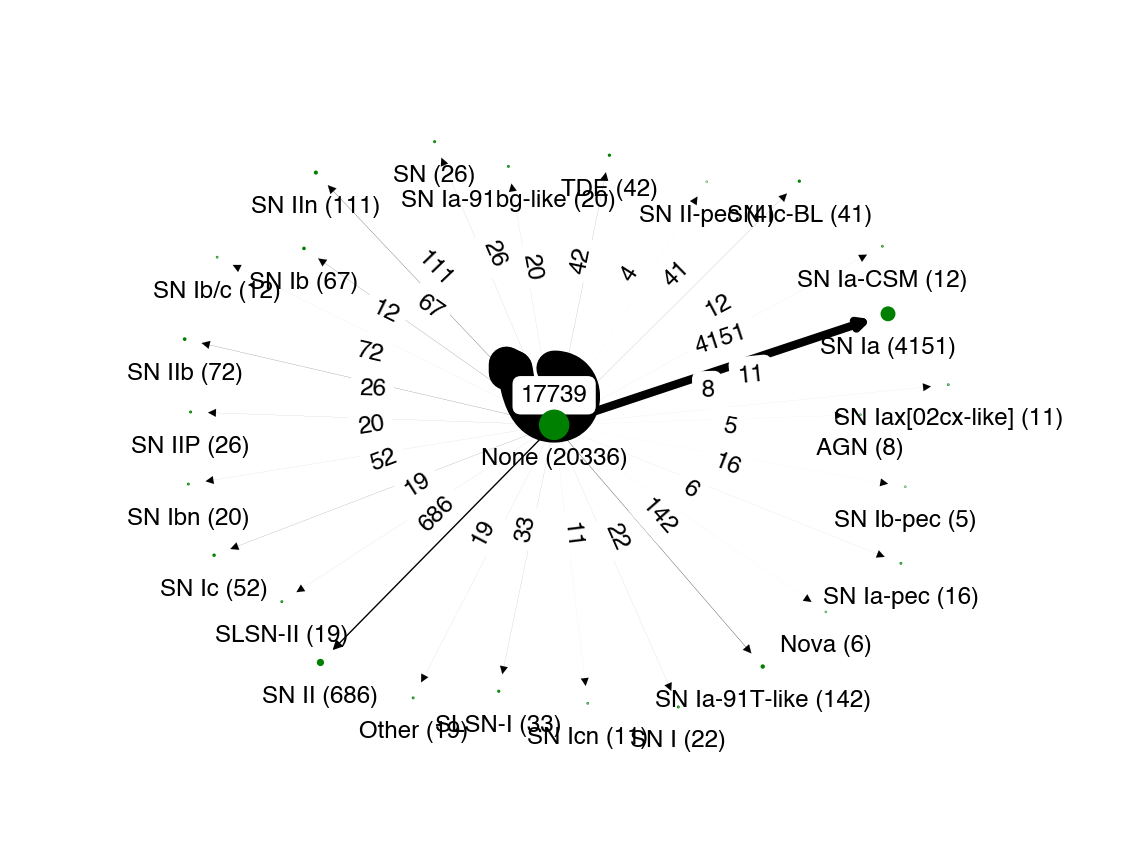

In [40]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

cls = 'None'
graph_df_cls = graph_df[graph_df.node == cls]


# Create a sample dataframe with node and edge data
df = graph_df_cls
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.DiGraph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]

# Scale the node sizes by the occurrences of the node
#node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
#print(node_sizes)

# explode the lists in the second column into separate rows
df = graph_df_cls
df_expl = df.explode('neighbors')

# group the data frame by the label column and count the number of unique values for each group
unique_node_d = dict(Counter(df['node']))
unique_neighbors_d = dict(Counter(df_expl['neighbors']))

for key in unique_neighbors_d:
    if key in unique_node_d:
        unique_node_d[key] += unique_neighbors_d[key]
    else:
        unique_node_d[key] = unique_neighbors_d[key]
        
node_count = unique_node_d
node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] +.1)
    
    
# # count the number of times of each node 
# node_count = dict(Counter(graph_df_cv['node']))

# # scale node sizes by frequency
# node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')


plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
#plt.savefig(f'../figures/graphs/{suffix}_size_scaled_None.jpg', dpi=300)
plt.show()


AGN


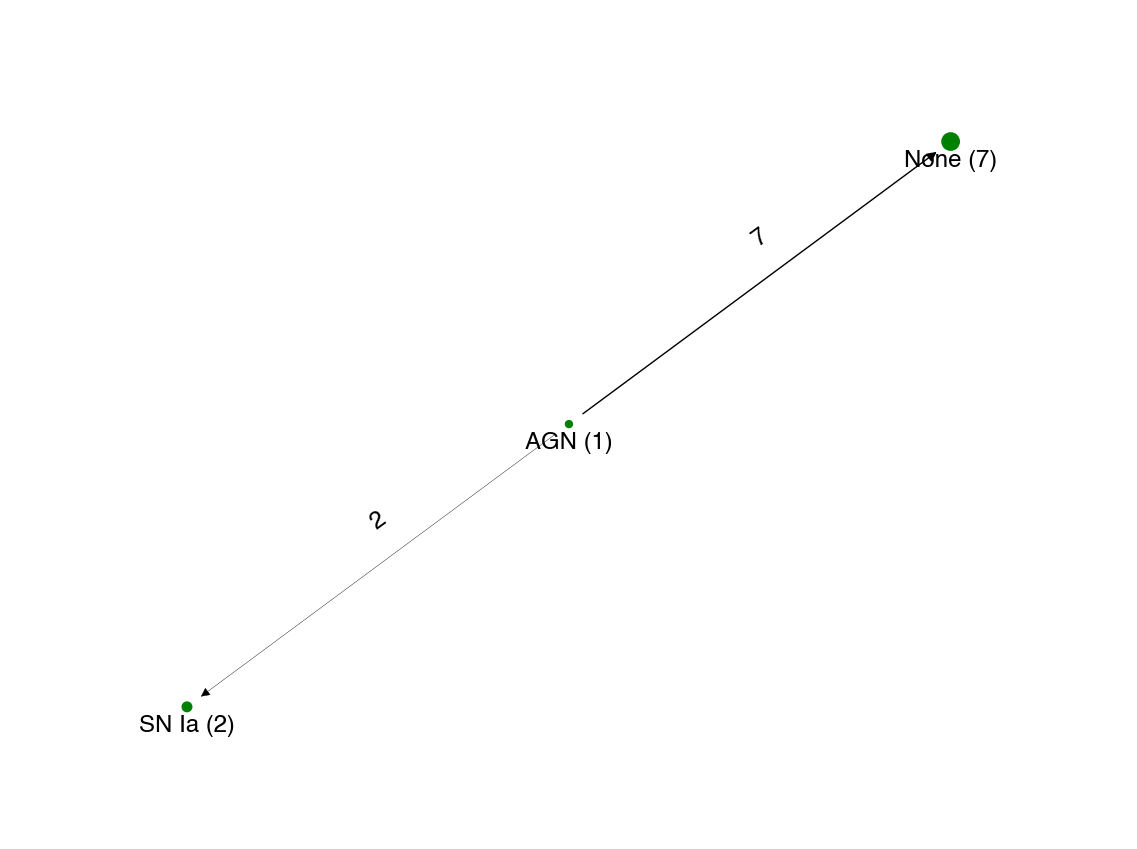

None


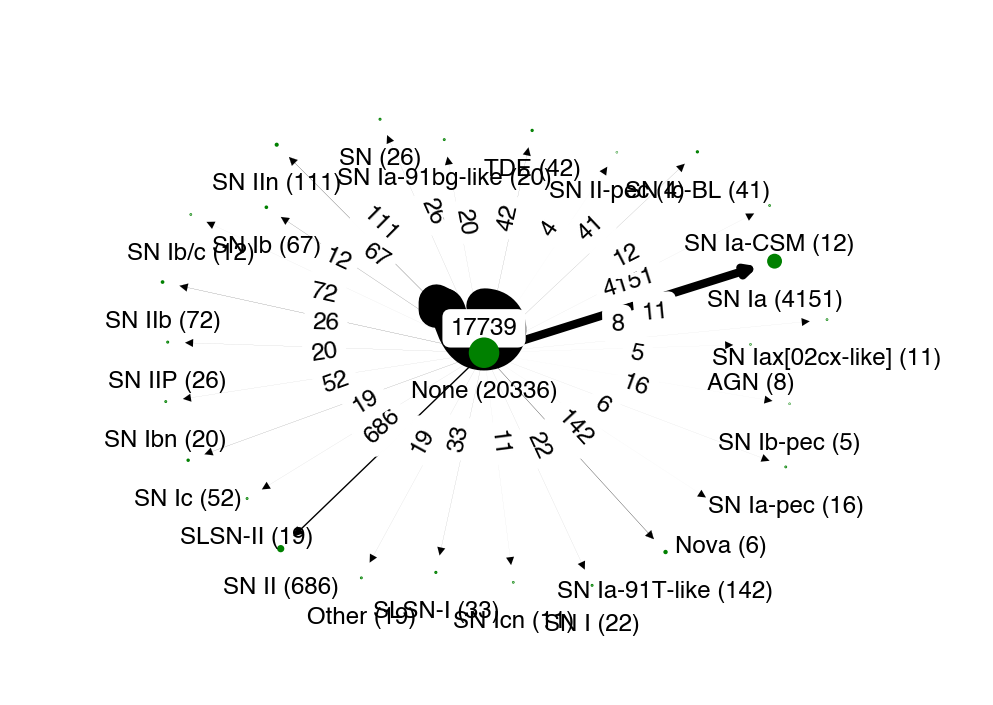

Nova


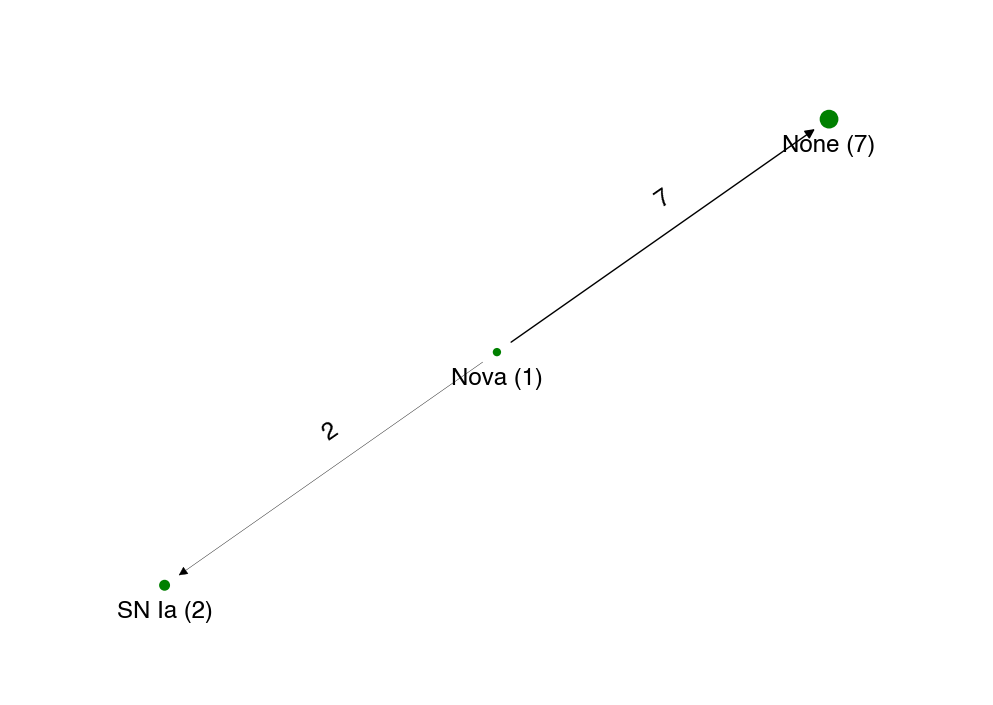

Other


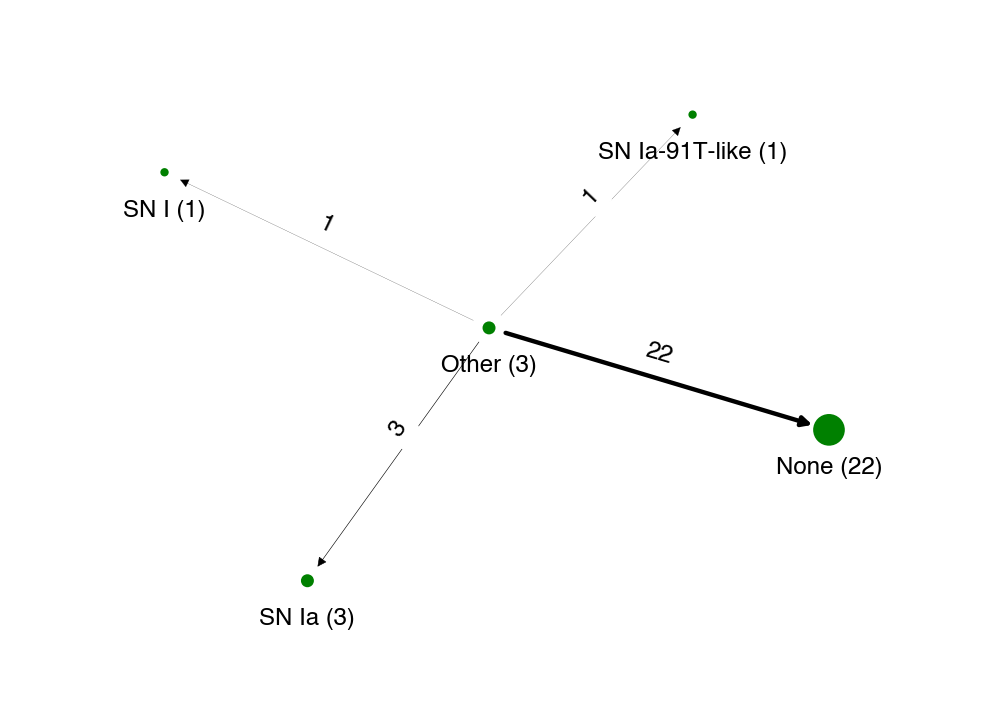

SLSN-I


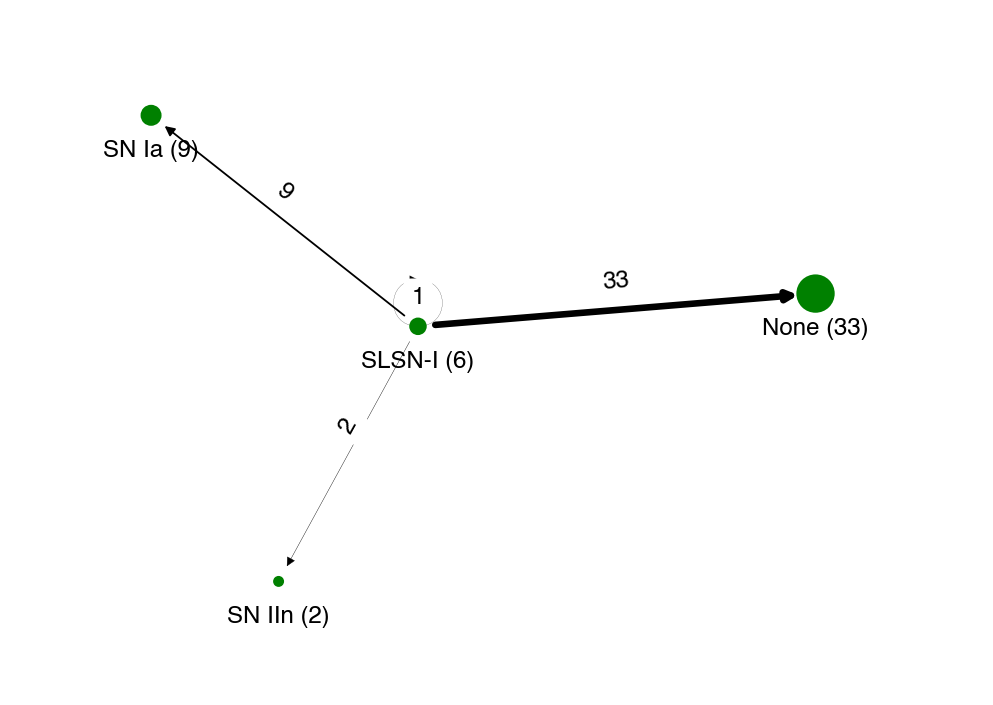

SLSN-II


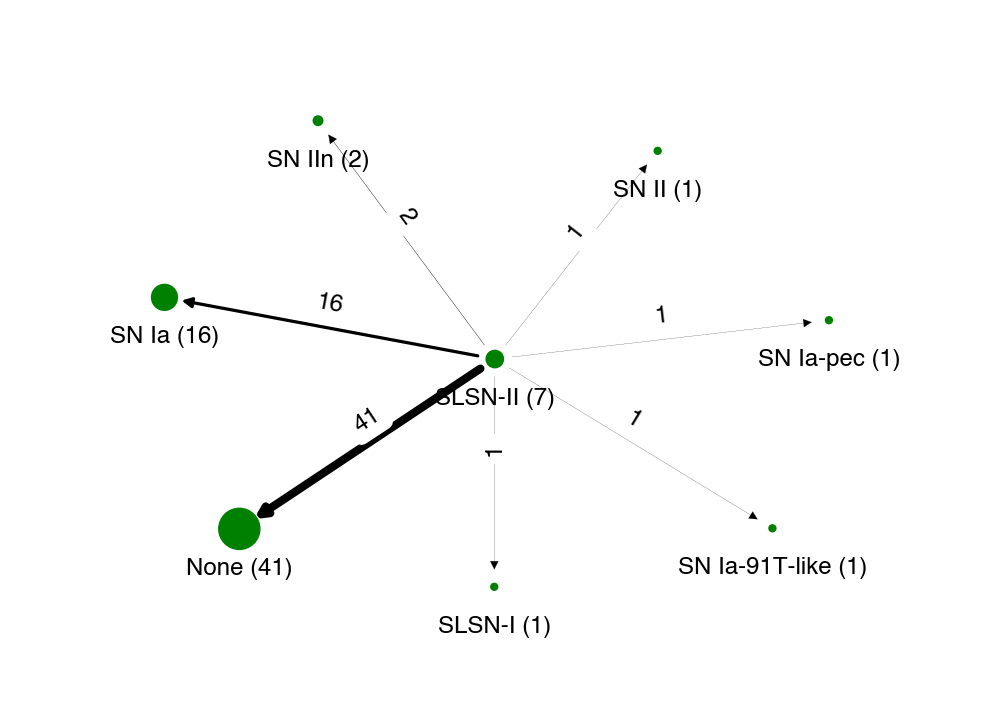

SN


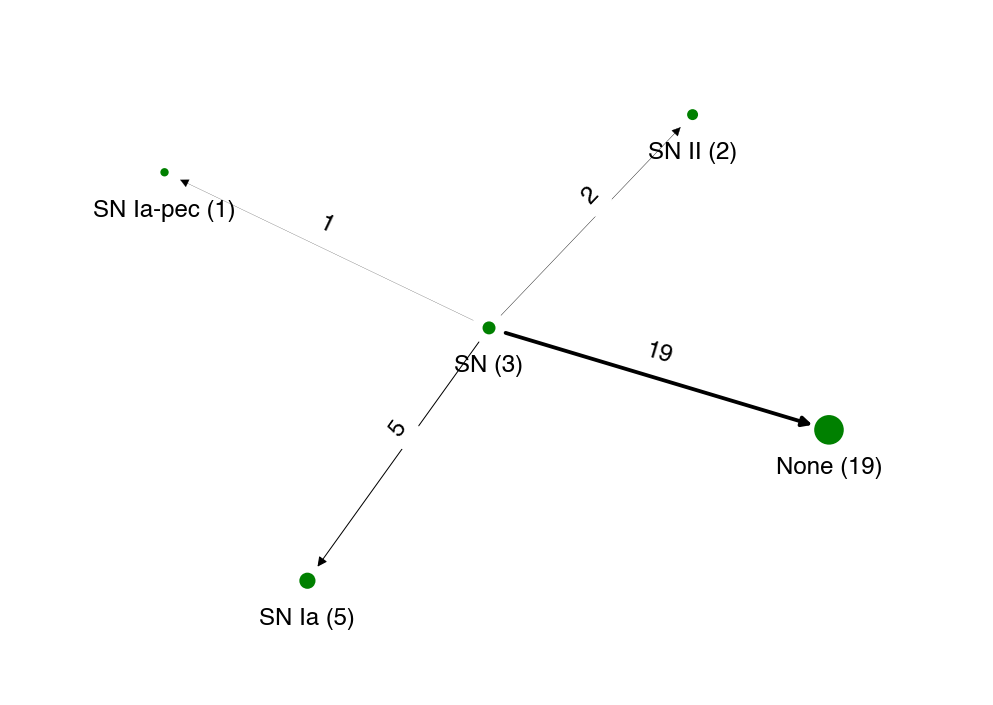

SN I


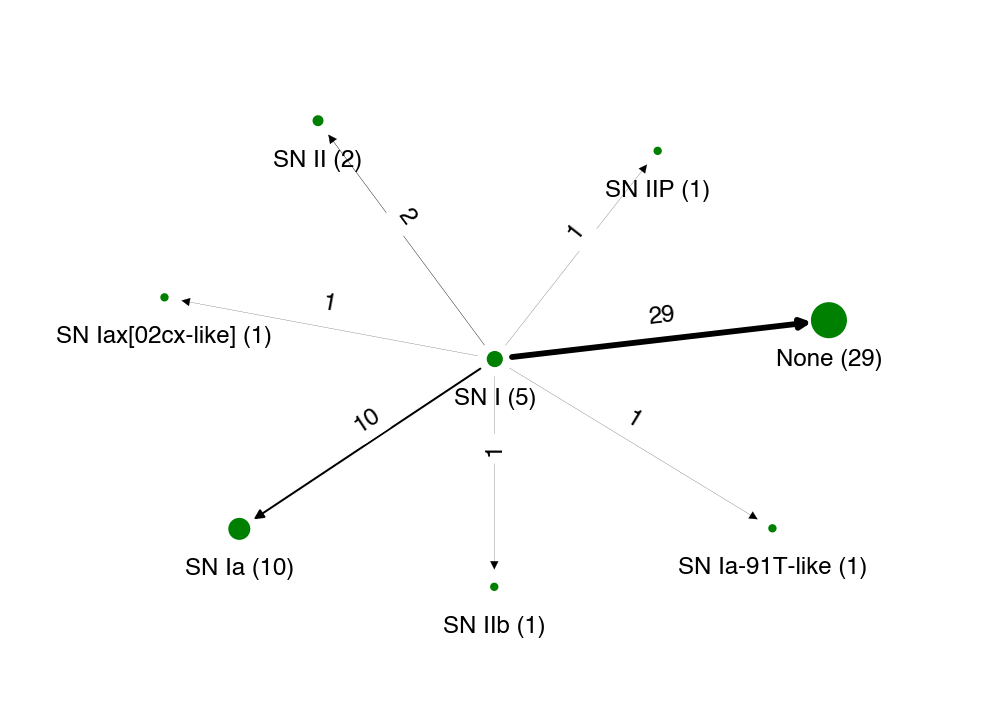

SN II


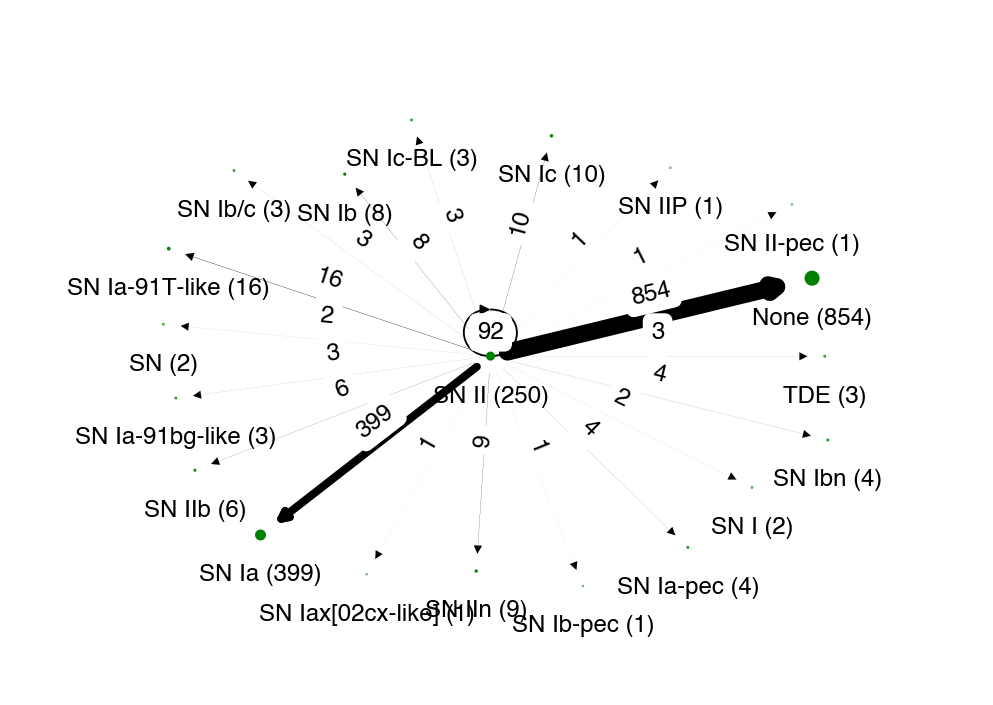

SN II-pec


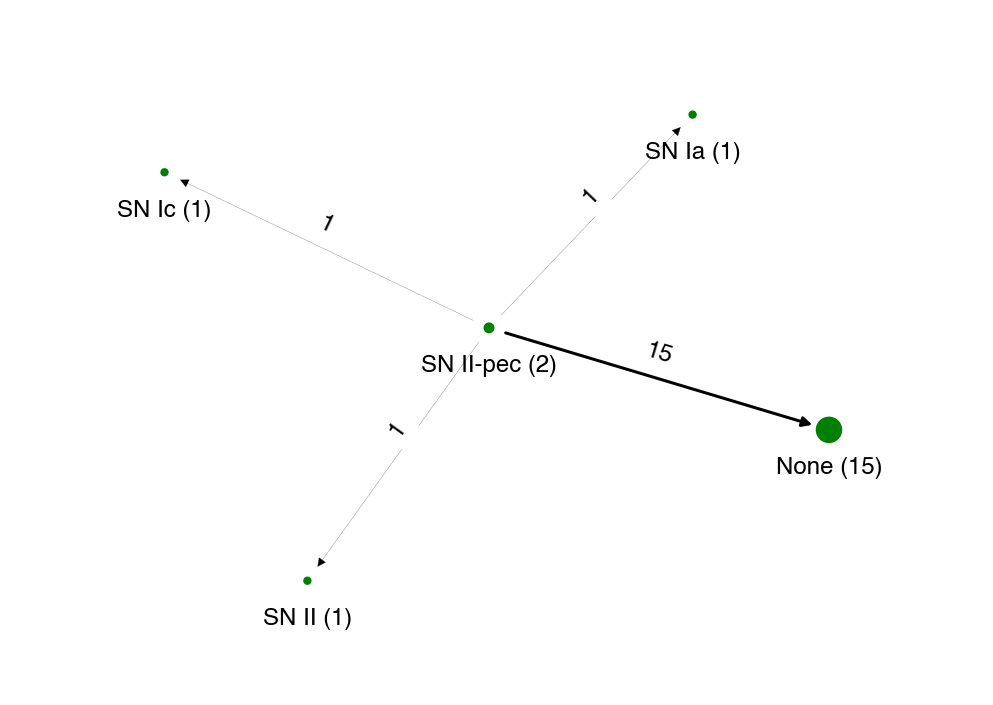

SN IIP


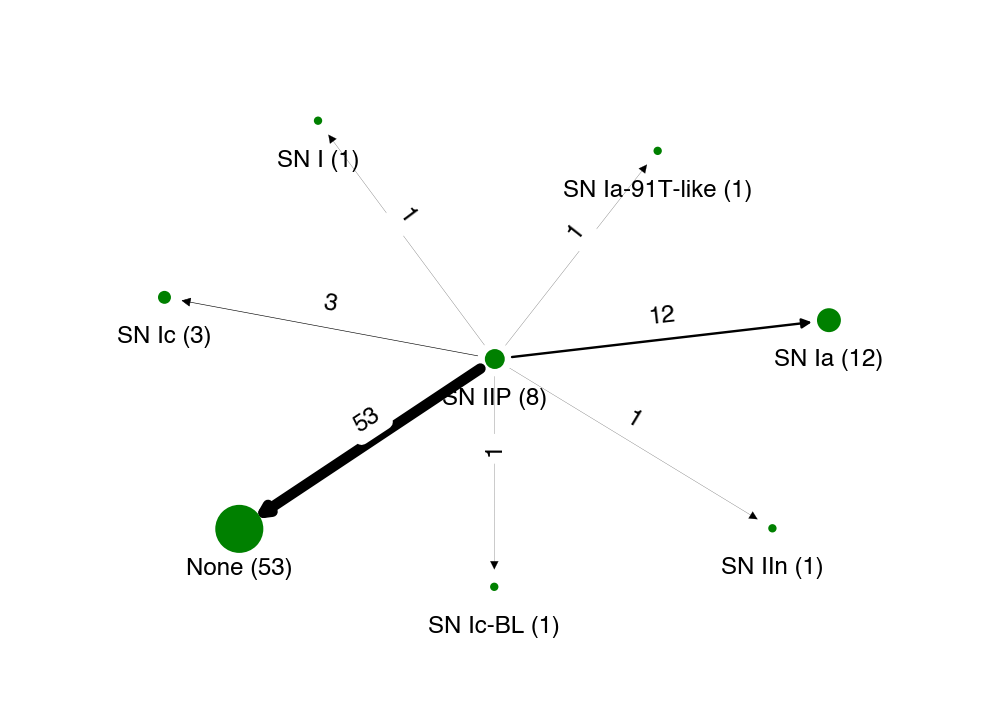

SN IIb


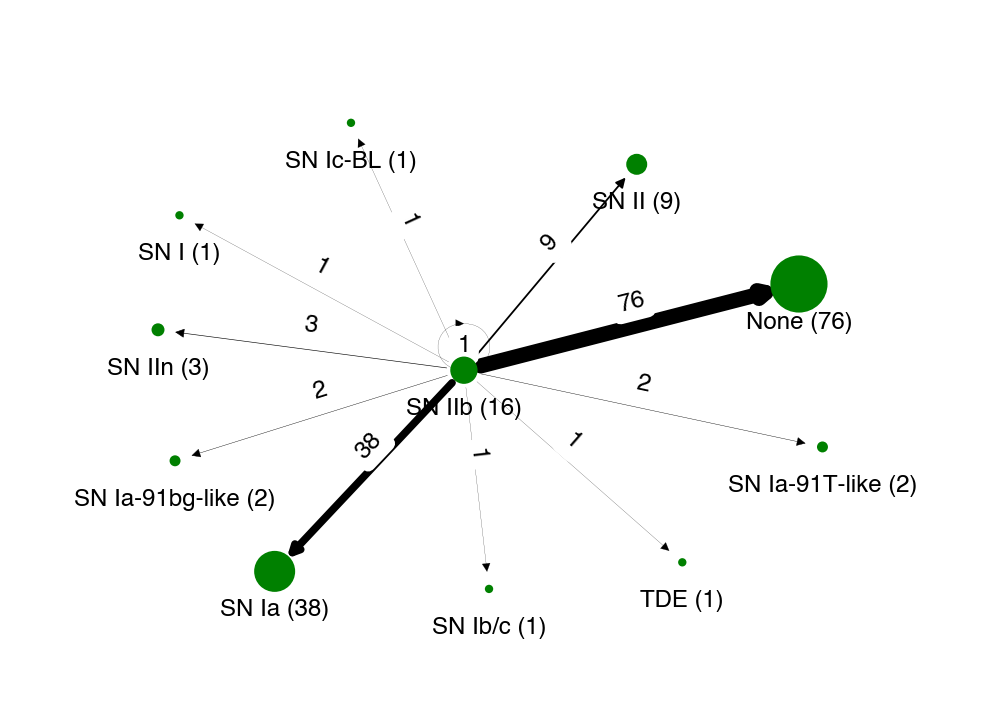

SN IIn


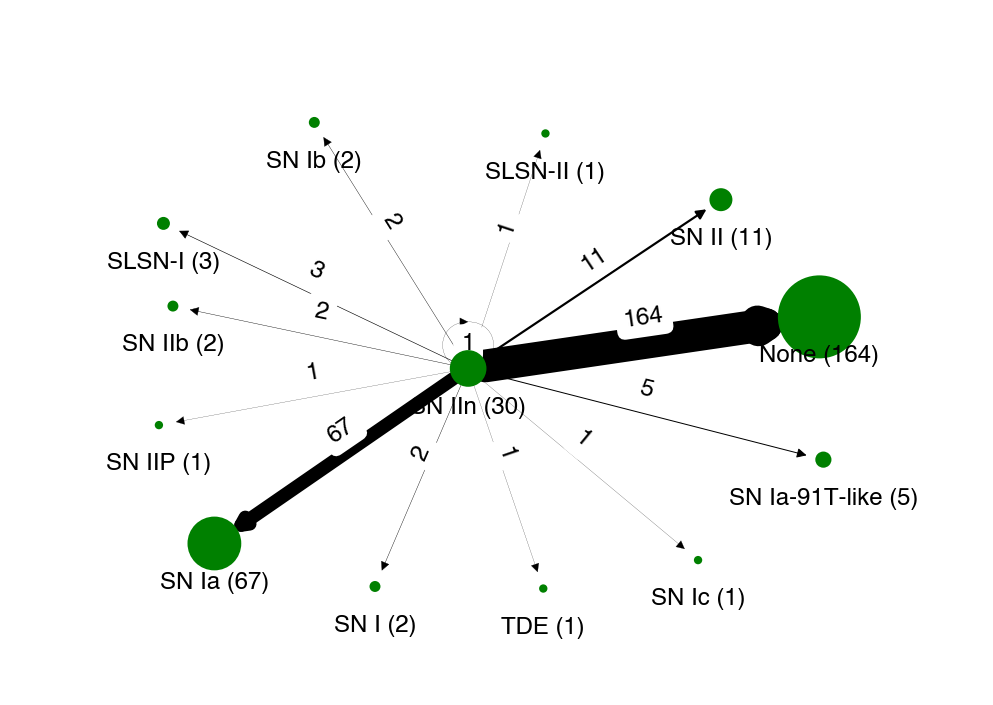

SN Ia


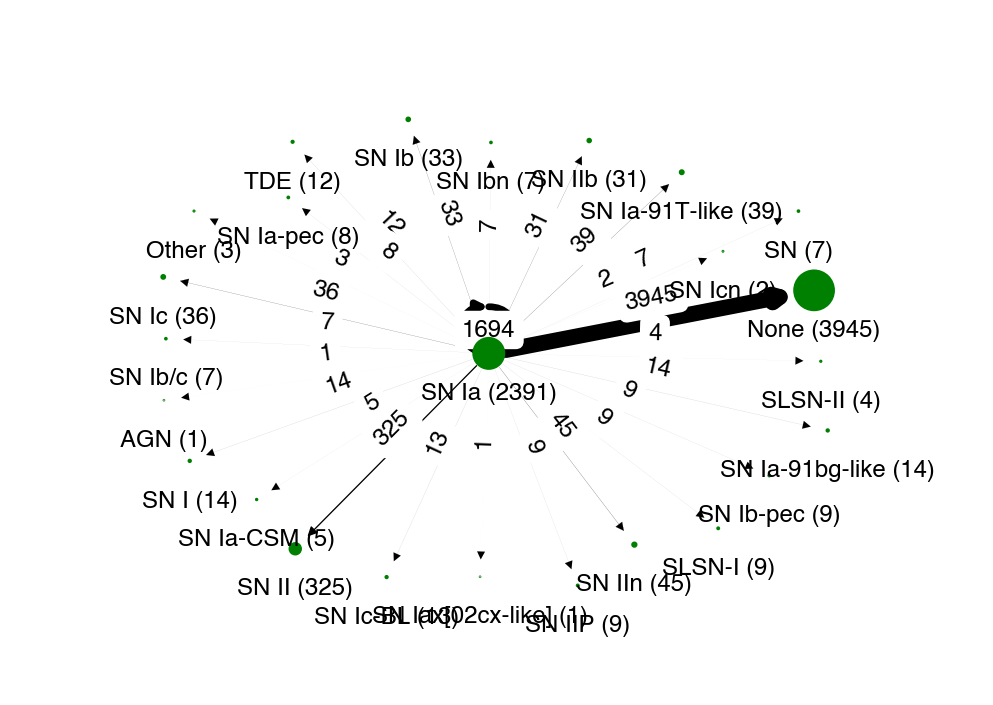

SN Ia-91T-like


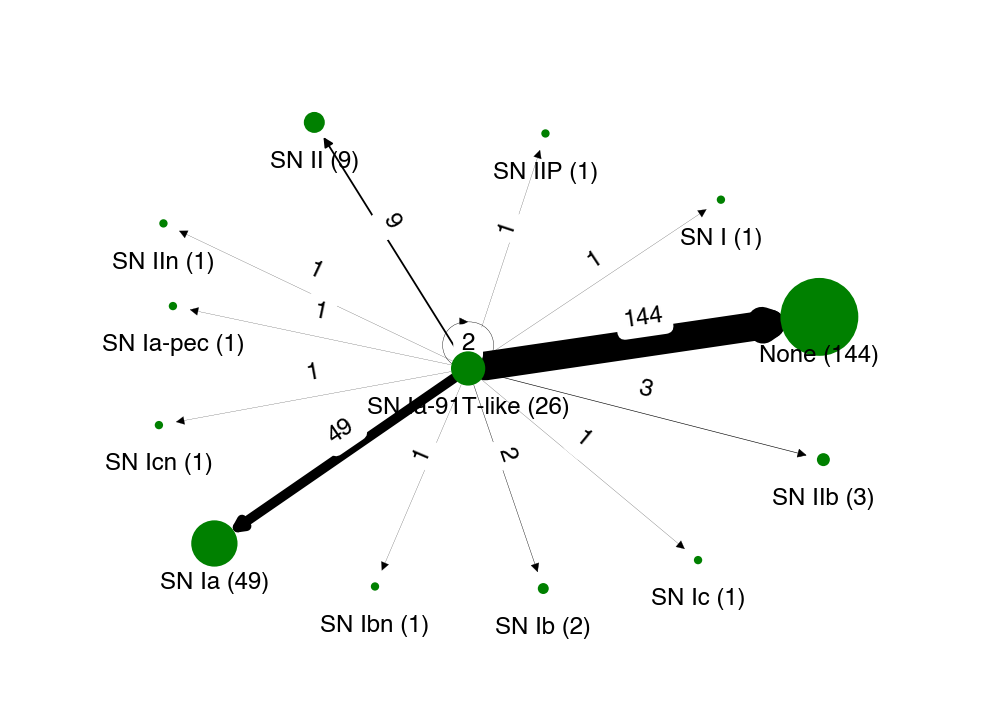

SN Ia-91bg-like


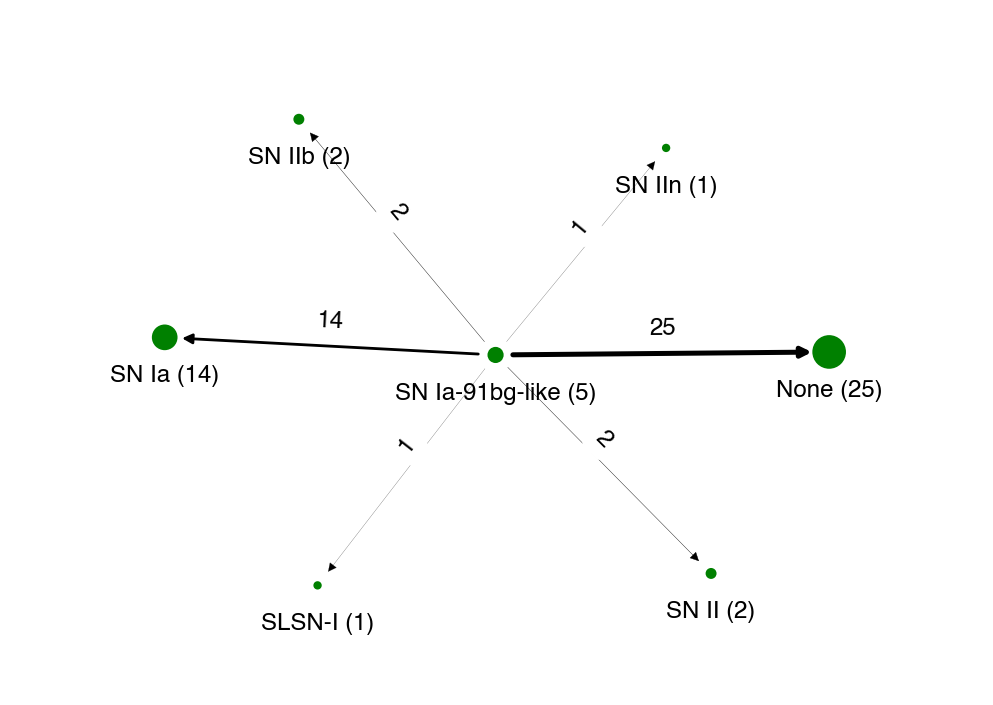

SN Ia-CSM


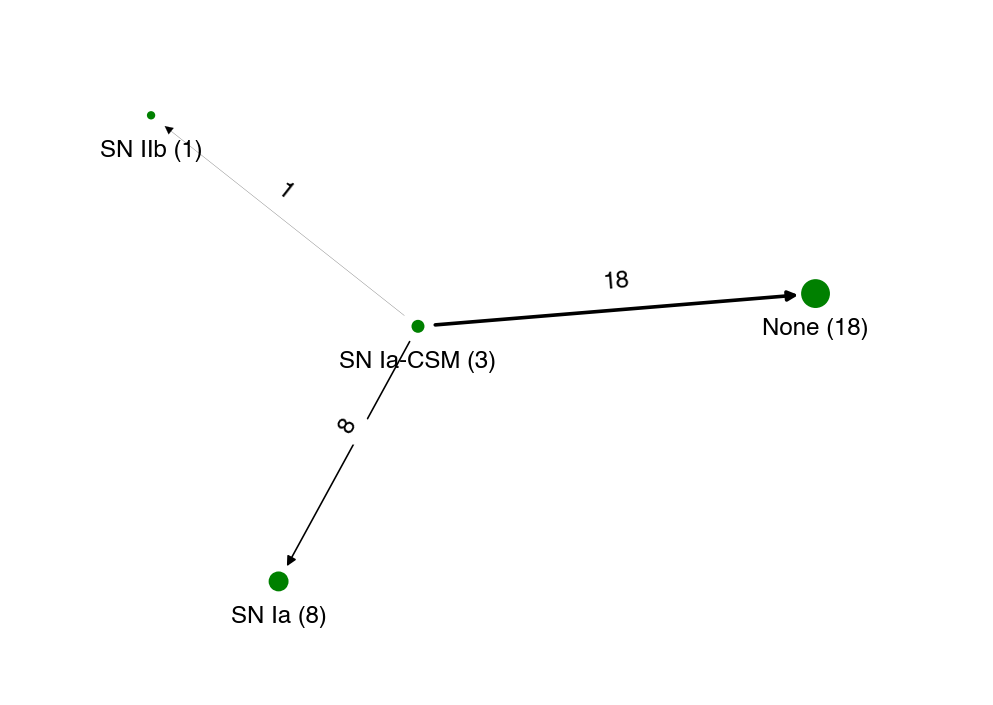

SN Ia-pec


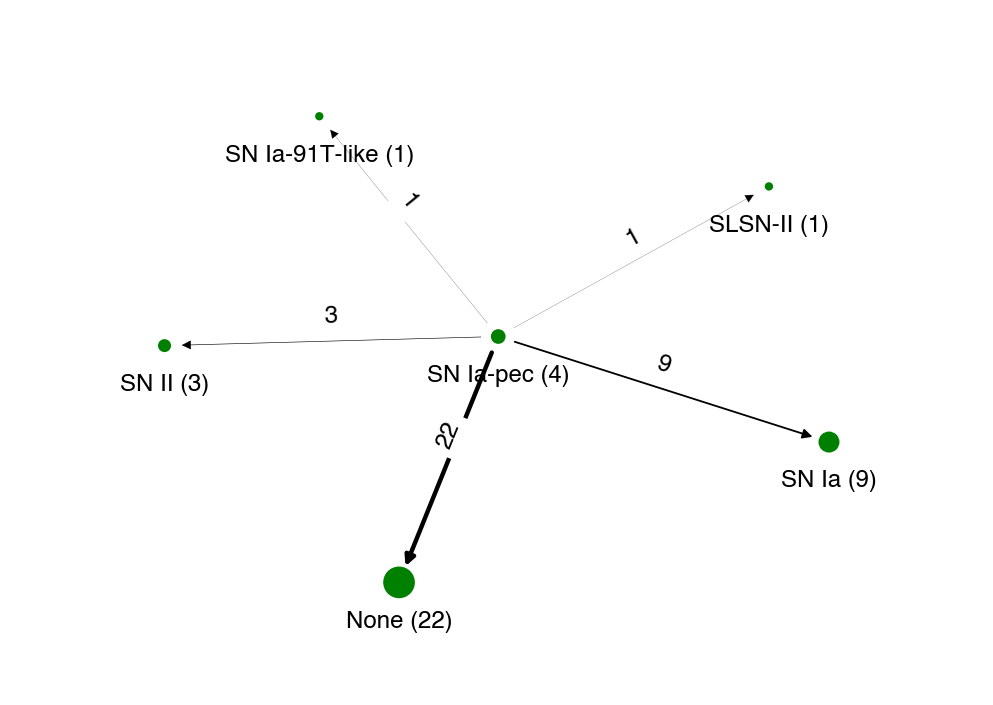

SN Iax[02cx-like]


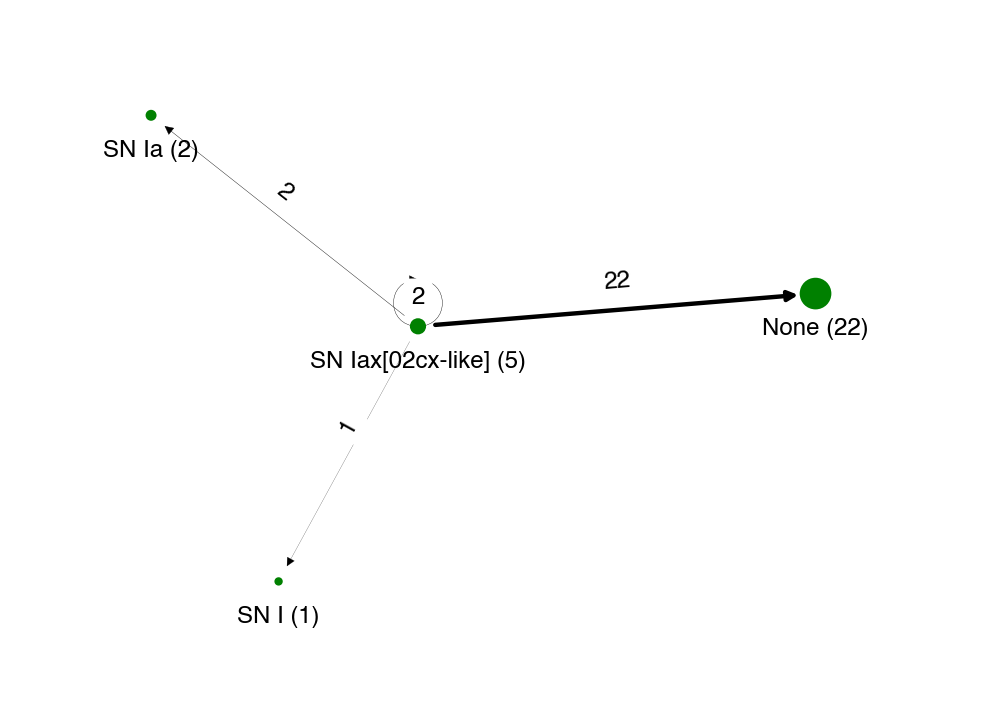

SN Ib


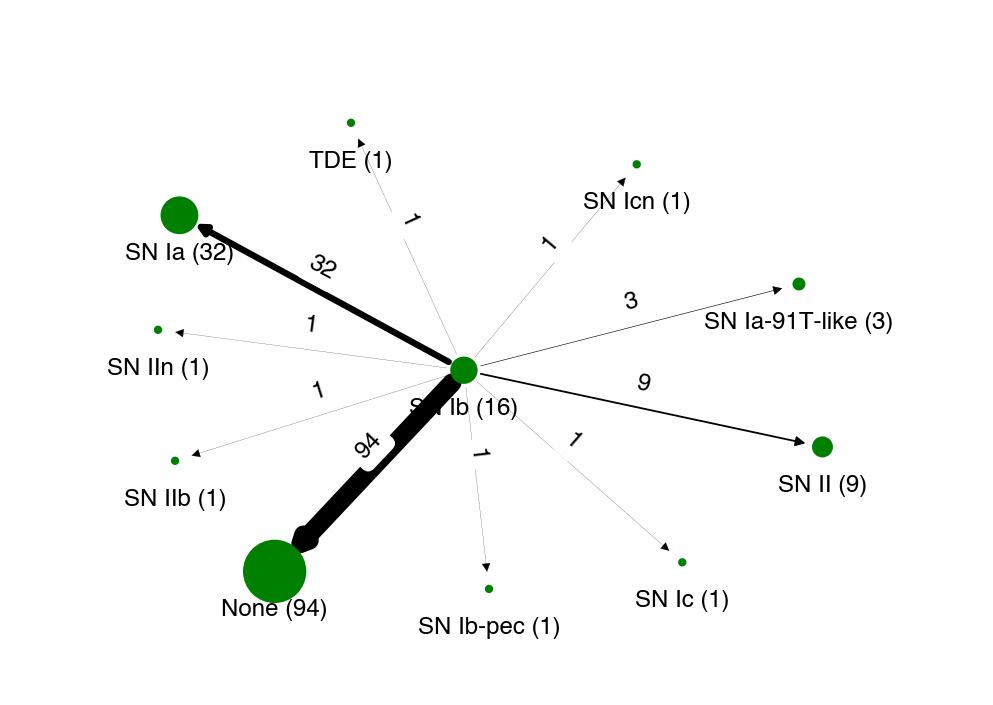

SN Ib-pec


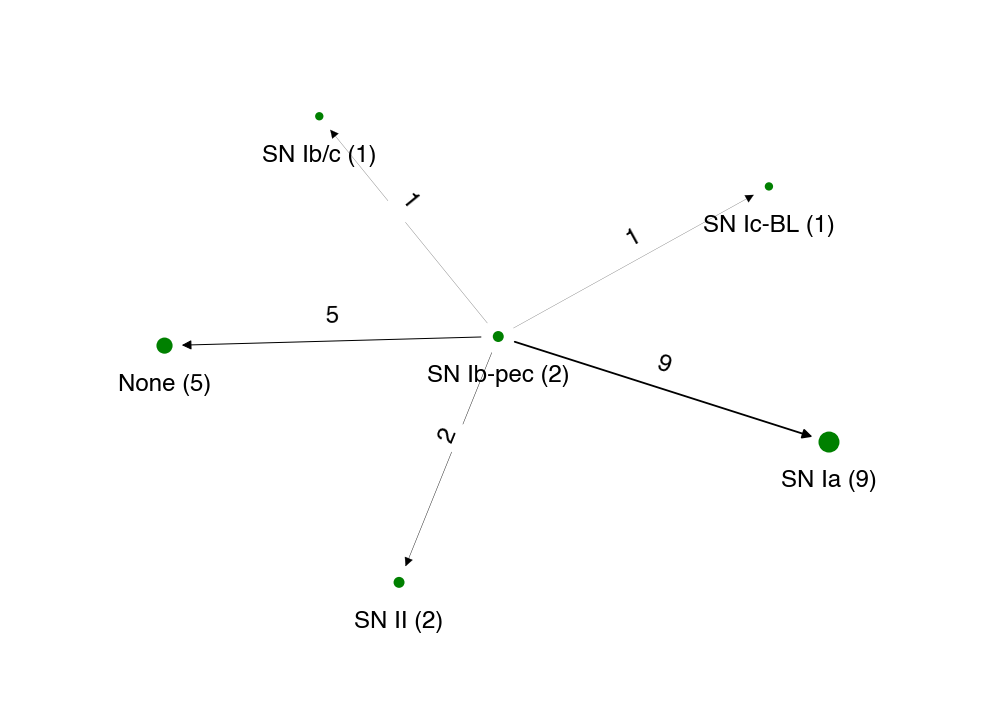

SN Ib/c


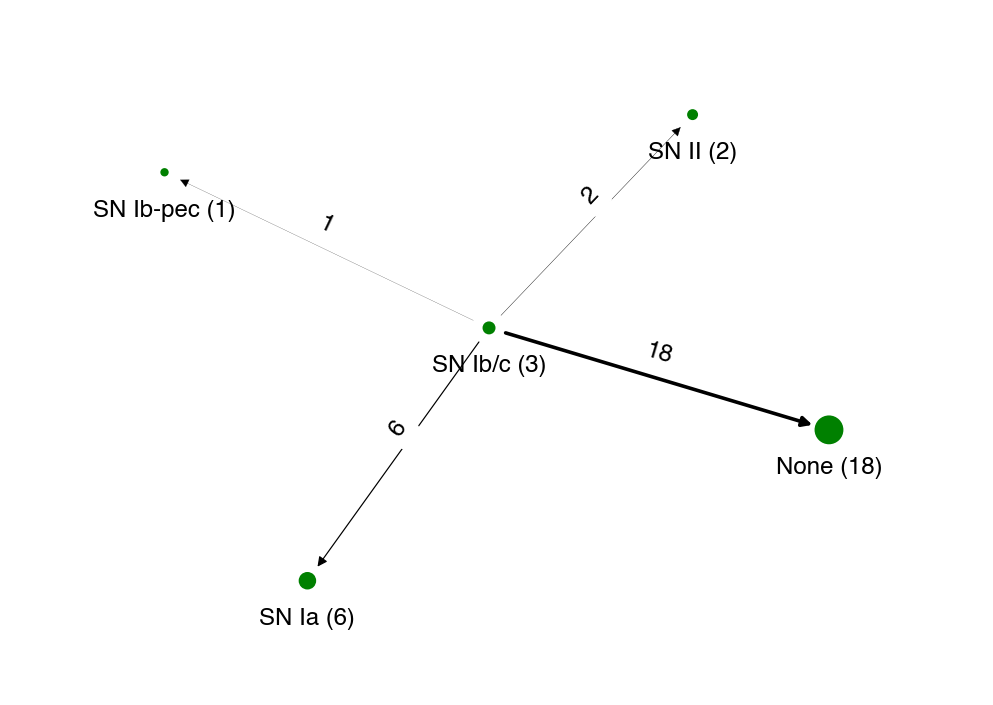

SN Ibn


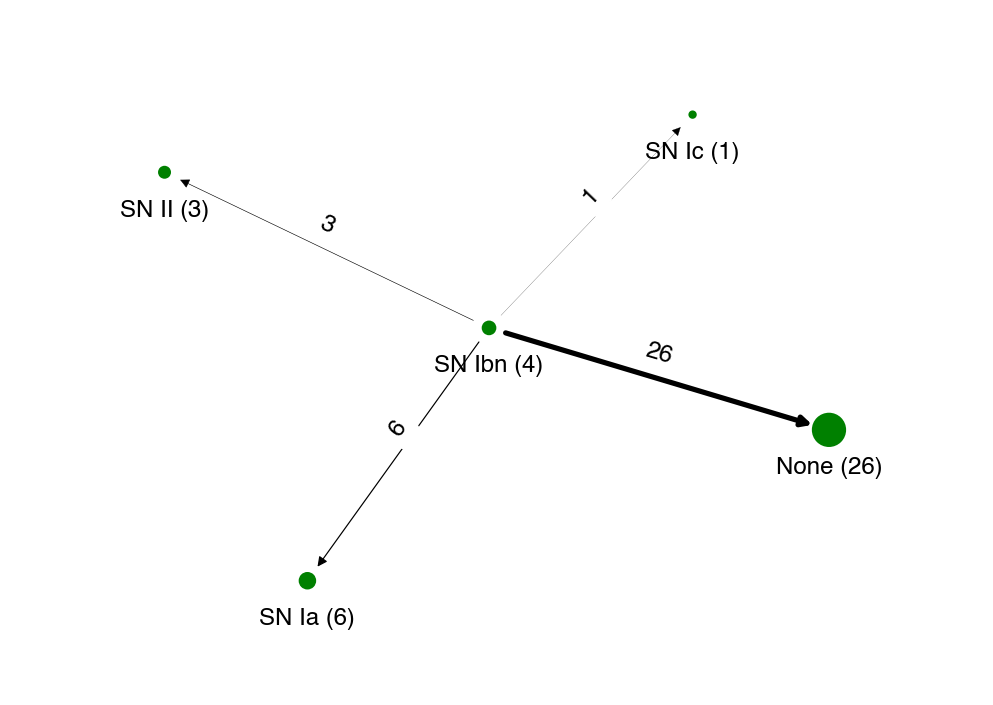

SN Ic


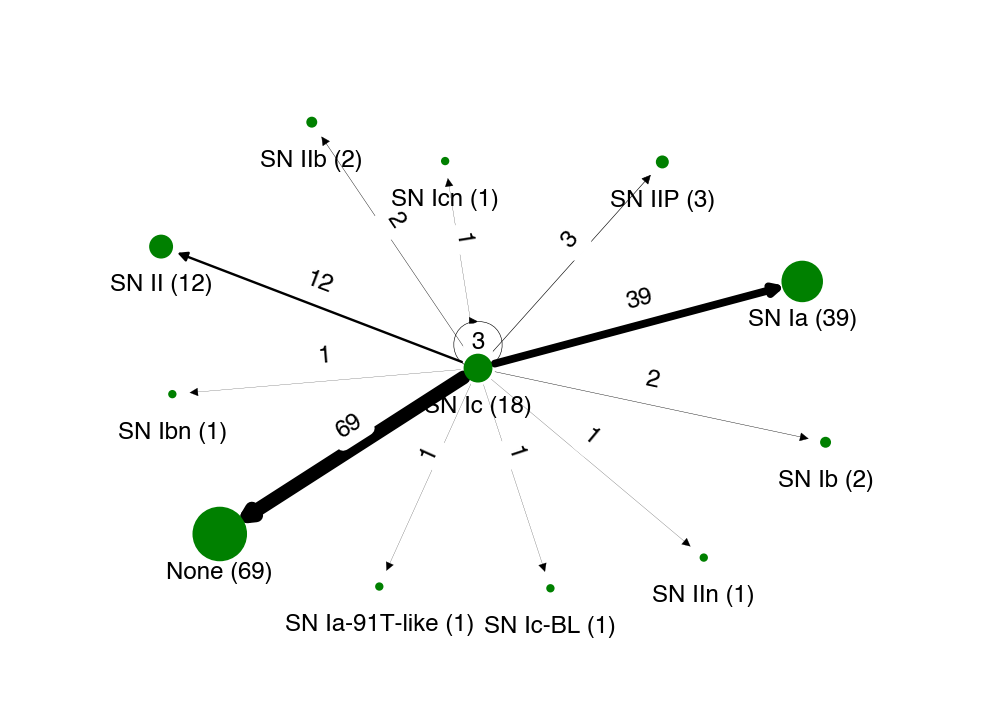

SN Ic-BL


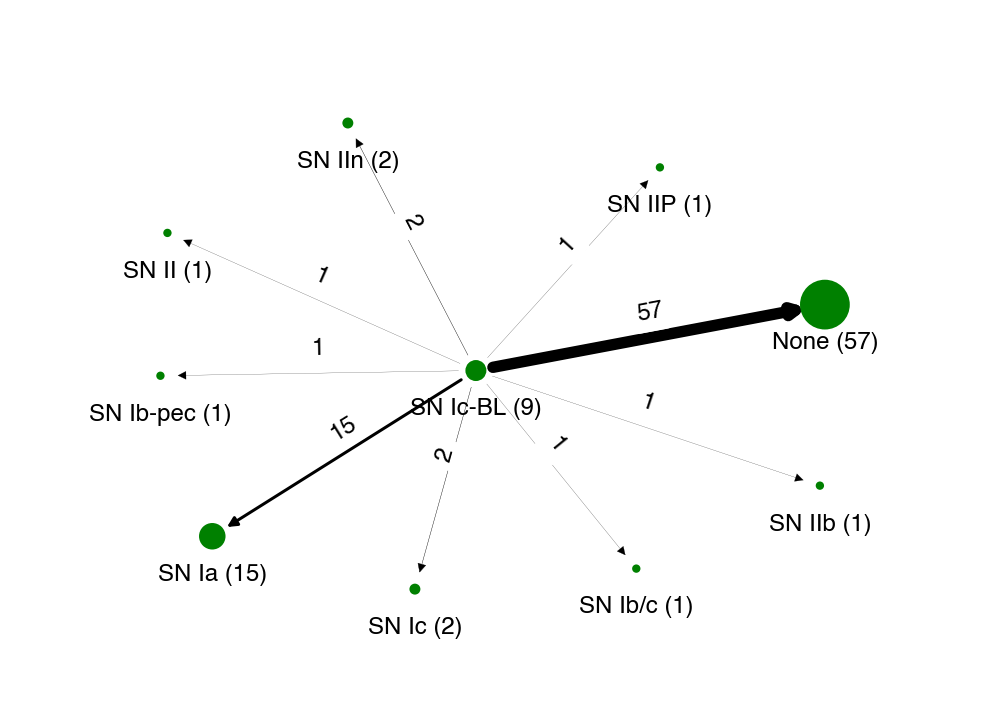

SN Icn


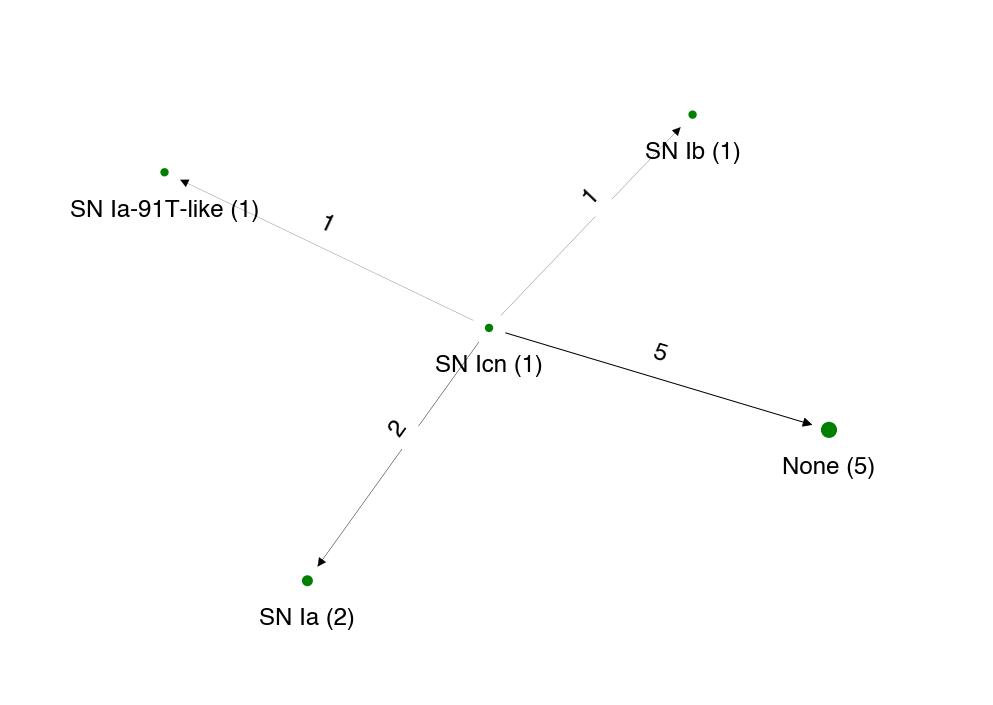

TDE


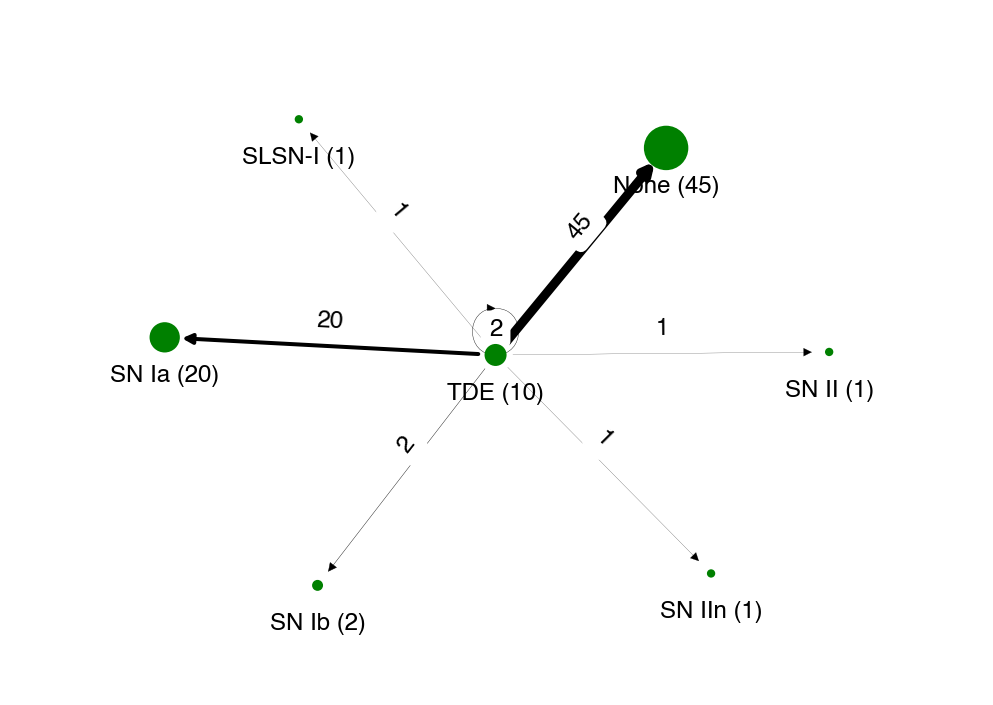

In [41]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

for cls in np.unique(graph_df['node']):
    print(cls)
    
    graph_df_cls = graph_df[graph_df.node == cls]


    # Create a sample dataframe with node and edge data
    df = graph_df_cls
    # Create a list of edges
    edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

    # Create a network graph from the edges
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Compute the frequency of each unique connection
    edge_freq = {}
    for u, v in edges:
        key = (min(u, v), max(u, v))
        edge_freq[key] = edge_freq.get(key, 0) + 1

    # Add edge labels with frequency
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        key = (min(u, v), max(u, v))
        #if edge_freq[key] >= 500:
        edge_labels[(u, v)] = str(edge_freq[key])

        # set edge widths based on frequency
        if cls == 'SN Ia': edge_widths = [int(edge_labels[edge])/500 for edge in edge_labels]
        elif cls == 'SN II': edge_widths = [int(edge_labels[edge])/100 for edge in edge_labels]
        elif cls == 'None': edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]
        else: edge_widths = [int(edge_labels[edge])/10 for edge in edge_labels]

        # Scale the node sizes by the occurrences of the node
        #node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        #print(node_sizes)

        # explode the lists in the second column into separate rows
        df_expl = df.explode('neighbors')

        # group the data frame by the label column and count the number of unique values for each group
        unique_node_d = dict(Counter(df['node']))
        unique_neighbors_d = dict(Counter(df_expl['neighbors']))

        for key in unique_neighbors_d:
            if key in unique_node_d:
                unique_node_d[key] += unique_neighbors_d[key]
            else:
                unique_node_d[key] = unique_neighbors_d[key]

    node_count = unique_node_d
    
    if cls == 'SN Ia': node_sizes = [node_count[node] * 0.1 for node in G.nodes()]
    elif cls == 'SN II': node_sizes = [node_count[node] * 0.05 for node in G.nodes()]
    elif cls == 'None': node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
    else: node_sizes = [node_count[node] * 10 for node in G.nodes()]
    #print(node_sizes)

    # Plot the graph
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

    # Move the labels of the nodes down right below the node
    pos_labels = {}
    for key, value in pos.items():
        pos_labels[key] = (value[0], value[1] +.1)


    # # count the number of times of each node 
    # node_count = dict(Counter(graph_df_cv['node']))

    # # scale node sizes by frequency
    # node_sizes = [node_count[node] * 9 for node in G.nodes()]

    # create labels with node and count information
    node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

    nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

    nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

    cls = cls.replace(' ', '').replace('/','')
#     plt.axis('off')
#     plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
#     plt.show()

    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.tight_layout()
    plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
    plt.show()
